In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/ABIDE/")

Mounted at /content/drive


In [ ]:
!pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install torch-geometric==2.2.0
import torch
print(torch.__version__)
print(torch.version.cuda)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 83.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.4.1+cu121
    Uninstalling torch-2.4.1+cu121:
      Successfully uninstalled torch-2.4.1+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.19.1+cu121
    Uninstalling torchvision-0.19.1+cu121:
      Successfully uninstalled torchvision-0.19.1+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.4.1+cu121
    Uninstalling torchaudio-2.4.1+cu121:
      Successfully uninstalled torchaudio-2.4.1+cu121
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 62.3 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-1.11

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ABIDE/')

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn import svm
import joblib
import openpyxl
from openpyxl import load_workbook
import os
import scipy.io as scio
import argparse
import numpy as np
import time
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torchvision.utils as vutils
from os.path import join
from os import listdir
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import DataLoader
from collections import OrderedDict
import nibabel as nib
import matplotlib.pyplot as plt
import cv2 as cv
from os import path
import shutil
import scipy.stats
import scipy.ndimage
import random
import torch.nn.init as init
import torch.nn.functional as F
import sys
import math
from functools import reduce
import operator
from scipy.interpolate import interp1d
from torch.optim import lr_scheduler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE

def feature_selection_fMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector
def feature_selection_sMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector

def get_index(lst=None, item=''):
	return [i for i in range(len(lst)) if lst[i] == item]

def flatten_one(length, img):
	'''
	  In some situations, the dimension on z-axis of images are smaller than
	  the dimension of z-axis of patches, this function will be used to pad
	'''

	one_line = np.zeros((1, int(length)))
	position = 0
	for i in range(img.shape[0]):  # column
		for j in range(i + 1, img.shape[1]):  # row
			one_line[0, position] = img[j, i]
			position = position + 1
	return one_line


def get_ids(num_subjects=None,dir_path=''):
	"""
	return:
		subject_IDs    : list of all subject IDs
	"""
	subject_IDs = np.genfromtxt(os.path.join(dir_path, 'subject_IDs.txt'), dtype=str)

	if num_subjects is not None:
		subject_IDs = subject_IDs[:num_subjects]

	return subject_IDs

def save_model(net,path, name_net):

  # This fucntion is used to save a specific model

    path_net =  path + '/' + name_net + '.pth'
    torch.save(net.cpu().state_dict(), path_net)
    net.cuda()

def load_model(net, path, name_net):

  # This function is used to load a specific model we saved before

    path_net =  path + '/' + name_net + '.pth'
    net.load_state_dict(torch.load(path_net))

    return net



In [ ]:
########################################### Load Data ###############################################
#####################################################################################################
#####################################################################################################
fMRI_atlas = 'CC200'  # AAL or CC200
phe = False

if phe == False:
  save_phe = '/without_phe/'
else:
  save_phe = '/with_phe/'


save_path = '/content/drive/MyDrive/ABIDE/save_models/CC200_sMRI/'+ save_phe
root_path_fMRI = '/content/dataset'
if os.path.exists(root_path_fMRI):
  shutil.rmtree(root_path_fMRI)
shutil.copytree('/content/drive/MyDrive/ABIDE/' + fMRI_atlas + '/original/', root_path_fMRI)
label_dir = '/content/drive/MyDrive/ABIDE/phenotypic_image_quality'

# sMRI path
localDir = '/content/sMRI_dataset/'
if os.path.exists(localDir):
  shutil.rmtree(localDir)
os.makedirs(localDir)
!unzip '/content/drive/MyDrive/ABIDE/freesurfer_stats.zip' -d '/content/sMRI_dataset'
localDir = localDir + 'freesurfer_stats/'


k_fold = 5
new_number_features_fMRI = 4000
new_number_features_sMRI = 800
number_samples = 871
useless_samples = ['51334']
if fMRI_atlas == 'AAL':
  image_size = [116, 116]
else:
  image_size = [200, 200]
scaler = True


age_name = 'ages.mat'
gender_name = 'genders.mat'
label_name = 'ABIDE_label_871.mat'
label = scio.loadmat(os.path.join(label_dir, label_name))
label = label['label'][0]
labels = np.zeros(number_samples - len(useless_samples))
site_name = 'sites.mat'
site = scio.loadmat(os.path.join(label_dir, site_name))
all_sites = site['sites']
for i in range(len(all_sites)):
	site = all_sites[i]
	all_sites[i] = site.replace(' ', '')
unique_sites = np.unique(all_sites)
sites = []
unique_sites = list(unique_sites)

gender = scio.loadmat(os.path.join(label_dir, gender_name))
gender = gender['genders']
genders = np.zeros((number_samples - len(useless_samples), 1))

age = scio.loadmat(os.path.join(label_dir, age_name))
age = age['ages']
ages = np.zeros((number_samples - len(useless_samples), 1))

subject_IDs = get_ids(number_samples,dir_path=label_dir)
subject_IDs = subject_IDs.tolist()
length = image_size[0] * (image_size[1]-1) / 2
fMRI_images = np.zeros((number_samples - len(useless_samples), int(length)))

position = 0
print('constructing fMRI features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    image_name = subject_name + '.mat'
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    image = scio.loadmat(os.path.join(root_path_fMRI, image_name))
    img = image['connectivity']

    idx = np.triu_indices_from(img, 1)
    fMRI_images[position, :] = img[idx]
    sites.append(all_sites[subject_index[0]])
    labels[position] = label[subject_index[0]]
    genders[position] = int(gender[subject_index[0]]) + 1
    ages[position] = float(age[subject_index[0]].replace(' ', ''))
    position = position + 1

if scaler == True:
	fMRI_images = StandardScaler().fit_transform(fMRI_images)

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/brainvol.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.DKTatlas.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.pial.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.thresh.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.curv.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.w-g.pct.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.DKTatlas.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.pial.stats  
  inflating: /c

In [ ]:
fMRI_feature_names = []
for i in range(1,img.shape[0]+1):
  for j in range(i+1,img.shape[0]+1):
    connection_brain_regions=[]
    connection_brain_regions.append(i)
    connection_brain_regions.append(j)
    fMRI_feature_names.append(connection_brain_regions)
print(fMRI_feature_names)

[[1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9], [1, 10], [1, 11], [1, 12], [1, 13], [1, 14], [1, 15], [1, 16], [1, 17], [1, 18], [1, 19], [1, 20], [1, 21], [1, 22], [1, 23], [1, 24], [1, 25], [1, 26], [1, 27], [1, 28], [1, 29], [1, 30], [1, 31], [1, 32], [1, 33], [1, 34], [1, 35], [1, 36], [1, 37], [1, 38], [1, 39], [1, 40], [1, 41], [1, 42], [1, 43], [1, 44], [1, 45], [1, 46], [1, 47], [1, 48], [1, 49], [1, 50], [1, 51], [1, 52], [1, 53], [1, 54], [1, 55], [1, 56], [1, 57], [1, 58], [1, 59], [1, 60], [1, 61], [1, 62], [1, 63], [1, 64], [1, 65], [1, 66], [1, 67], [1, 68], [1, 69], [1, 70], [1, 71], [1, 72], [1, 73], [1, 74], [1, 75], [1, 76], [1, 77], [1, 78], [1, 79], [1, 80], [1, 81], [1, 82], [1, 83], [1, 84], [1, 85], [1, 86], [1, 87], [1, 88], [1, 89], [1, 90], [1, 91], [1, 92], [1, 93], [1, 94], [1, 95], [1, 96], [1, 97], [1, 98], [1, 99], [1, 100], [1, 101], [1, 102], [1, 103], [1, 104], [1, 105], [1, 106], [1, 107], [1, 108], [1, 109], [1, 110], [1, 111], [1, 1

In [ ]:
sMRI_feature_names = []

############################################### Load sMRI ###############################################################
############################################### Load sMRI ###############################################################
############################################### Load sMRI ###############################################################
############################################### Load Desikan_Killiany_features
left = 'lh.aparc.stats'
right = 'rh.aparc.stats'
number_roi = 68
feature_list = ['NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
names = ['StructName', 'NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
skiprows= list(range(0,61))
Desikan_Killiany_features = np.zeros((number_samples - len(useless_samples), number_roi * len(feature_list)))


position = 0
print('constructing Desikan-Killiany Atlas features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    table_left = pd.read_table(localDir + subject_name + '/' + left, sep='\s+', names=names,
						  skiprows=skiprows)
    table_right = pd.read_table(localDir + subject_name + '/' + right, sep='\s+', names=names,
						  skiprows=skiprows)
    if i == 0:
      left_names = table_left['StructName'].values.tolist()
      left_names = [['ctx-lh-'+k] for k in left_names]
      right_names = table_right['StructName'].values.tolist()
      right_names = [['ctx-rh-'+k] for k in right_names]

    for j in range(len(feature_list)):
      feature_name = feature_list[j]
      left_features = table_left[feature_name].values.tolist()
      right_features = table_right[feature_name].values.tolist()
      all_features = left_features + right_features
      if len(all_features) != number_roi:
       print('The sample ' + subject_name + ' has mistake!')
      all_features = np.array(all_features)
      Desikan_Killiany_features[position, j*number_roi : (j+1)*number_roi] = all_features

      if i == 0:
        left_dk_names = [ [*k,feature_name] for k in left_names]
        right_dk_names = [ [*k,feature_name] for k in right_names]
        sMRI_feature_names = sMRI_feature_names + left_dk_names + right_dk_names
    position = position + 1

if scaler == True:
	for i in range(len(feature_list)):
		Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi] = StandardScaler().fit_transform(Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi])

print('finished')




############################################### Load aseg features
print('constructing aseg features')
number_roi_aseg = 45
aseg = 'aseg.stats'
feature_list_aseg = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_aseg = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_aseg= list(range(0,79))
aseg_features = np.zeros((number_samples - len(useless_samples), number_roi_aseg * len(feature_list_aseg)))

position = 0
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		table_left = pd.read_table(localDir + subject_name + '/' + aseg, sep='\s+', names=names_aseg,
						  skiprows=skiprows_aseg)
		if i == 0:
			left_names = table_left['Structure Name'].values.tolist()
			left_names = [[k] for k in left_names]

		for j in range(len(feature_list_aseg)):
			feature_name = feature_list_aseg[j]
			left_features = table_left[feature_name].values.tolist()
			if len(left_features) != number_roi_aseg:
				print('The sample ' + subject_name + ' has mistake!')
			all_features = np.array(left_features)
			aseg_features[position, j*number_roi_aseg : (j+1)*number_roi_aseg] = all_features
			if i == 0:
				as_names = [[*k,feature_name] for k in left_names]
				sMRI_feature_names = sMRI_feature_names + as_names


		position = position + 1

if scaler == True:
	for i in range(len(feature_list_aseg)):
		aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg] = StandardScaler().fit_transform(aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg])
print('finished')



############################################### Load wmparc features
number_roi_wmparc = 70
wmparc = 'wmparc.stats'
feature_list_wmparc = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_wmparc = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_wmparc= list(range(0,65))
wmparc_features = np.zeros((number_samples - len(useless_samples), number_roi_wmparc * len(feature_list_wmparc)))

print('constructing wmparc features')
position = 0
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		table_left = pd.read_table(localDir + subject_name + '/' + wmparc, sep='\s+', names = names_wmparc,
						  skiprows=skiprows_wmparc)

		if i == 0:
			left_names = table_left['Structure Name'].values.tolist()
			left_names = [[k] for k in left_names]
		for j in range(len(feature_list_wmparc)):
			feature_name = feature_list_wmparc[j]
			left_features = table_left[feature_name].values.tolist()
			if len(left_features) != number_roi_wmparc:
				print('The sample ' + subject_name + ' has mistake!')
			all_features = np.array(left_features)
			wmparc_features[position, j*number_roi_wmparc : (j+1)*number_roi_wmparc] = all_features

			if i == 0:
				wm_names = [[*k,feature_name] for k in left_names]
				sMRI_feature_names = sMRI_feature_names + wm_names

		position = position + 1
if scaler == True:
	for i in range(len(feature_list_wmparc)):
		wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc] = StandardScaler().fit_transform(wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc])
print('finished')

############################################### concatenation
sMRI_features = np.concatenate((Desikan_Killiany_features, aseg_features, wmparc_features),axis = 1)
print(sMRI_feature_names)
print(len(sMRI_feature_names))

constructing Desikan-Killiany Atlas features
The index for sample 51334 is :  [799]
finished
constructing aseg features
The index for sample 51334 is :  [799]
finished
constructing wmparc features
The index for sample 51334 is :  [799]
finished
[['ctx-lh-bankssts', 'NumVert'], ['ctx-lh-caudalanteriorcingulate', 'NumVert'], ['ctx-lh-caudalmiddlefrontal', 'NumVert'], ['ctx-lh-cuneus', 'NumVert'], ['ctx-lh-entorhinal', 'NumVert'], ['ctx-lh-fusiform', 'NumVert'], ['ctx-lh-inferiorparietal', 'NumVert'], ['ctx-lh-inferiortemporal', 'NumVert'], ['ctx-lh-isthmuscingulate', 'NumVert'], ['ctx-lh-lateraloccipital', 'NumVert'], ['ctx-lh-lateralorbitofrontal', 'NumVert'], ['ctx-lh-lingual', 'NumVert'], ['ctx-lh-medialorbitofrontal', 'NumVert'], ['ctx-lh-middletemporal', 'NumVert'], ['ctx-lh-parahippocampal', 'NumVert'], ['ctx-lh-paracentral', 'NumVert'], ['ctx-lh-parsopercularis', 'NumVert'], ['ctx-lh-parsorbitalis', 'NumVert'], ['ctx-lh-parstriangularis', 'NumVert'], ['ctx-lh-pericalcarine', 'NumV

In [ ]:
print(sMRI_features.shape)
print(len(sMRI_feature_names))

(870, 1417)
1417


In [ ]:
dist_train = {}
dist_validation = {}
dist_test = {}
for i in range(k_fold):
	dist_train[str(i + 1)] = []
	dist_validation[str(i + 1)] = []
	dist_test[str(i + 1)] = []

for each_site in unique_sites:
	index_site = get_index(sites, each_site)
	label = np.zeros((len(index_site)))
	for i in range(len(index_site)):
		index = index_site[i]
		label[i] = int(labels[int(index)])
	########################################### StratifiedKFold ####################################################
	sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
	group = 0
	for train, validation in sfolder.split(index_site,label):
		for i in train:
			dist_train[str(group + 1)].append(index_site[i])
			name = 0
		for j in validation:
			dist_validation[str(group + 1)].append(index_site[j])
			name = 0
		group = group+1

	group = 0
	for train, validation in sfolder.split(index_site,label):
		if group == 0:
			for j in validation:
				dist_test[str(group + k_fold)].append(index_site[j])
				dist_train[str(group + k_fold)].remove(index_site[j])
		else:
			for j in validation:
				dist_test[str(group)].append(index_site[j])
				dist_train[str(group)].remove(index_site[j])
		group = group+1


for i in range(k_fold):
	print(len(dist_test[str(i+1)]))

177
174
170
167
182


In [ ]:
import torch.nn as nn
############################################### AUTO model ###############################################################
############################################### AUTO model ###############################################################
############################################### AUTO model ###############################################################
class Stacked_autoencoder(nn.Module):
	def __init__(self, in_c, hid_1, hid_2, hid_3, out, dropout_rate):

		super(Stacked_autoencoder, self).__init__()
		self.linear_1 = nn.Linear(in_features=in_c, out_features=hid_1)
		self.linear_2 = nn.Linear(in_features=hid_1, out_features=hid_2)
		self.linear_3 = nn.Linear(in_features=hid_2, out_features=hid_3)
		self.linear_4 = nn.Linear(in_features=hid_3, out_features=out)
		self.relu = nn.ReLU(inplace=True)
		self.dropout = nn.Dropout(dropout_rate)

	def forward(self, data):

		input_data = torch.flatten(data, start_dim=1, end_dim=-1)
		lin1 = self.relu(self.dropout(self.linear_1(input_data)))
		lin2 = self.relu(self.linear_2(lin1))
		lin3 = self.relu(self.linear_3(lin2))
		lin4 = self.relu(self.linear_4(lin3))

		return lin4

class MLP(nn.Module):
	def __init__(self, in_c, hid_1, hid_2, out, dropout_rate):

		super(MLP, self).__init__()
		self.linear_1 = nn.Linear(in_features=in_c, out_features=hid_1)
		self.linear_2 = nn.Linear(in_features=hid_1, out_features=hid_2)
		self.linear_3 = nn.Linear(in_features=hid_2, out_features=out)
		self.relu = nn.ReLU(inplace=True)
		self.dropout = nn.Dropout(dropout_rate)

	def forward(self, data):

		lin1 = self.relu(self.linear_1(data))
		lin2 = self.dropout(self.relu(self.linear_2(lin1)))
		lin3 = self.linear_3(lin2)

		return lin3


class Auto_encoder_MLP(nn.Module):
	def __init__(self, in_c, auto_1, auto_2, auto_3, MLP_1, MLP_2, MLP_out, dropout_rate):

		super(Auto_encoder_MLP, self).__init__()
		self.auto_encoder = Stacked_autoencoder(in_c, auto_1, auto_2, auto_3, in_c, dropout_rate)
		self.MLP = MLP(in_c, MLP_1, MLP_2, MLP_out, dropout_rate)
		self.softmax = nn.LogSoftmax(dim=1)

	def forward(self, data):

		auto_output = self.auto_encoder(data)
		MLP_out = self.MLP(auto_output)
		out = self.softmax(MLP_out)

		return out, auto_output


In [ ]:
AUTO_labels = np.zeros((number_samples - len(useless_samples), 2))
for i in range(len(labels)):
    if labels[i] == 1:
        AUTO_labels[i,0] = 1
    else:
        AUTO_labels[i,1] = 1

# data = {}
# for fold in range(1, 1+1):

#   data[str(fold)] = []
#   selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
#   selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)

#   new_fMRI_data = selector_fMRI.transform(fMRI_images)
#   new_sMRI_data = selector_sMRI.transform(sMRI_features)
#   ################################################# combine ##########################################
#   if phe == True:
#     fold_data = np.concatenate((new_fMRI_data,new_sMRI_data,phe_features), axis = 1)
#     print(fold_data.shape)
#   else:
#     fold_data = np.concatenate((new_fMRI_data,new_sMRI_data), axis = 1)
#     print(fold_data.shape)

#   data[str(fold)].append(fold_data)
#   data[str(fold)].append(FCN_labels)


In [ ]:
############################################### Train, validaiton, test pipelines ###############################################################
############################################### Train, validaiton, test pipelines ###############################################################
############################################### Train, validaiton, test pipelines ###############################################################
def train_AUTO(args, model, all_data, fold_train_index, fold_validation_index, fold_test_index, scheduler):

    model.train()
    loss_function=torch.nn.MSELoss()

    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=True)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()


    if args.cuda:
        data, target = data.cuda(), target.cuda()

    data_train = data[fold_train_index,:]
    target = target[fold_train_index, :]
    scheduler.zero_grad()
    out,out_auto = model(data_train)

    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])
    data2 = torch.squeeze(data_train)
    MSE_loss = loss_function(out_auto,data2)
    total_loss = cross_loss + MSE_loss
    total_loss.backward()
    scheduler.step()

    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()

    ############################## validation and test ################################################################################
    val_target, val_out, val_loss = validation_AUTO(args, model, all_data, fold_validation_index)
    test_target, test_out, test_out_prob, test_loss = test_AUTO(args, model, all_data, fold_test_index)

    return model, target, out, total_loss.item(), val_target, val_out,val_loss, test_target, test_out, test_out_prob, test_loss


def validation_AUTO(args, model,all_data,  fold_validation_index):

    model.eval()
    loss_function=torch.nn.MSELoss()
    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()


    if args.cuda:
        data, target = data.cuda(), target.cuda()


    data_val = data[fold_validation_index,:]
    target = target[fold_validation_index, :]
    out,out_auto = model(data_val)

    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])
    data2 = torch.squeeze(data_val)
    MSE_loss = loss_function(out_auto,data2)
    total_loss = cross_loss + MSE_loss

    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()

    return target, out, total_loss.item()


def test_AUTO(args, model, all_data,  fold_test_index):

    model.eval()
    loss_function=torch.nn.MSELoss()

    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()


    if args.cuda:
        data, target = data.cuda(), target.cuda()

    data_test = data[fold_test_index,:]
    target = target[fold_test_index, :]
    out,out_auto = model(data_test)

    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])
    data2 = torch.squeeze(data_test)
    MSE_loss = loss_function(out_auto,data2)
    total_loss = cross_loss + MSE_loss

    out_prob = torch.exp(out)
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    out_prob = out_prob.cpu().detach().numpy()

    return target, out, out_prob, total_loss.item()



In [ ]:
########################################### Training setting ################################################
########################################### Training setting ################################################
########################################### Training setting ################################################
parser = argparse.ArgumentParser()
parser.add_argument('--ngpu', type=int, default=1)
parser.add_argument('--nEpochs', type=int, default=200)
parser.add_argument('--no-cuda', action='store_true')
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--lr', type=str, default=8e-4)
# I define three kinds of optimizer, adam sgd and rmsprop, but adam performs the best
parser.add_argument('--opt', type=str, default='adam')
parser.add_argument('--auto_in', type=int, default=new_number_features_fMRI+new_number_features_sMRI)
parser.add_argument('--auto_hid_1', type=int, default=500)
parser.add_argument('--auto_hid_2', type=int, default=150)
parser.add_argument('--auto_hid_3', type=int, default=500)
parser.add_argument('--MLP_1', type=int, default=300)
parser.add_argument('--MLP_2', type=int, default=16)
parser.add_argument('--MLP_out', type=int, default=2)
parser.add_argument('--dropout_rate', type=int, default=0.5)


args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

gpu_ids = range(args.ngpu)
train = train_AUTO


In [ ]:
data = {}
for fold in range(1, 1+1):
  data[str(fold)] = []
  # selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
  selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)

  # new_fMRI_data = selector_fMRI.transform(fMRI_images)
  ranking_sMRI = selector_sMRI.ranking_
  print(ranking_sMRI)
  print(max(ranking_sMRI))
  array_ranking = np.array(ranking_sMRI)
  index = np.where(array_ranking==1)
  print(len(index[0]))
  print(index[0])
  new_sMRI_data = selector_sMRI.transform(sMRI_features)
  test_sMRI_data = sMRI_features[:,index[0]]
  print(test_sMRI_data)
  print(new_sMRI_data)


Fitting estimator with 1417 features.
Fitting estimator with 1317 features.
Fitting estimator with 1217 features.
Fitting estimator with 1117 features.
Fitting estimator with 1017 features.
Fitting estimator with 917 features.
Fitting estimator with 817 features.
[1 1 5 ... 4 4 1]
8
800
[   0    1    3    9   10   13   15   18   20   22   25   26   28   29
   33   34   35   38   39   42   43   44   46   48   49   56   57   58
   62   63   68   72   73   77   78   79   83   84   85   86   90   93
   96   99  100  104  105  106  107  108  110  112  114  116  124  125
  126  128  129  130  131  133  134  136  139  142  145  147  148  151
  152  153  154  155  156  157  158  160  161  162  165  166  167  169
  170  172  173  175  176  178  182  184  185  187  189  190  192  193
  194  195  200  202  203  204  205  207  209  210  211  212  214  215
  219  220  221  222  223  226  227  229  230  232  233  234  235  237
  238  239  240  241  243  244  245  246  247  248  249  250  252  253
  

In [ ]:
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

class aefcn_VanillaGrad(object):

    def __init__(self, pretrained_model, cuda=False):
        self.pretrained_model = pretrained_model
        self.features = pretrained_model._modules["module"]
        self.cuda = cuda

    def __call__(self, all_data,subject_index, index=None):

#################################################################################################################
#################################################################################################################

        input_data = torch.from_numpy(all_data[0])
        input_data = Variable(input_data, requires_grad=True)
        input_data = input_data.float()

        target = torch.from_numpy(all_data[1])
        target = target.float().long()


        if self.cuda:
          input_data, target = input_data.cuda(), target.cuda()
#################################################################################################################
        # output,out_auto = model_vanilla(input_data)
        output, out_auto = self.pretrained_model(input_data)
        output = output[subject_index, :]
        one_hot = np.zeros((1, output.size()[0]), dtype=np.float32)
        if index is None:
            # This part needs to be looked again
            # for k in range(output.size()[0]):
            each_index = np.argmax(output.data.cpu().numpy())
            one_hot[0][each_index] = 1
        else:
            one_hot[0][index] = 1

        if self.cuda:
            one_hot = Variable(torch.from_numpy(one_hot).cuda(), requires_grad=True)
        else:
            one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
        one_hot = torch.sum(one_hot * output)

        # This step is very important, if we don't define it in advance, then the grad is None
        input_data.retain_grad()
        one_hot.backward(retain_graph=True)

        # The shape is 870 * 4800
        grad_features = input_data.grad.data.cpu().numpy()
        # The shape is 60876, 1

        return grad_features




class aefcn_SmoothGrad(aefcn_VanillaGrad):

    def __init__(self, pretrained_model, cuda=False, stdev_spread=0.15,
                 n_samples=25, magnitude=True):
        super(aefcn_SmoothGrad, self).__init__(pretrained_model, cuda)
        """
        self.pretrained_model = pretrained_model
        self.features = pretrained_model.features
        self.cuda = cuda
        self.pretrained_model.eval()
        """
        self.stdev_spread = stdev_spread
        self.n_samples = n_samples
        self.magnitutde = magnitude

    def __call__(self, all_data, subject_index, index=None):
#################################################################################################################
#################################################################################################################
        # input_data = torch.from_numpy(all_data[0])
        # input_data = Variable(input_data, requires_grad=True)
        # input_data = input_data.float()

        target = torch.from_numpy(all_data[1])
        target = target.float().long()


        # x = all_data[0]
        # stdev = self.stdev_spread * (np.max(x) - np.min(x))
        # total_gradients = np.zeros_like(x)
        # for i in range(self.n_samples):
        #     noise = np.random.normal(0, stdev, x.shape).astype(np.float32)
        #     x_plus_noise = x + noise
        #     if self.cuda:
        #         x_plus_noise = Variable(torch.from_numpy(x_plus_noise).cuda(), requires_grad=True)
        #         x_plus_noise = x_plus_noise.float()
        #         target, edge_index, edgenet_input = target.cuda(), edge_index.cuda(), edgenet_input.cuda()
        #     else:
        #         x_plus_noise = Variable(torch.from_numpy(x_plus_noise), requires_grad=True)
        #         x_plus_noise = x_plus_noise.float()

        x = all_data[0]
        print(np.max(x))
        print(np.min(x))
        print(np.max(x[subject_index,:]))
        print(np.min(x[subject_index,:]))
        stdev = self.stdev_spread * (np.max(x[subject_index,:]) - np.min(x[subject_index,:]))
        total_gradients = np.zeros_like(x)
        for i in range(self.n_samples):
            noise = np.random.normal(0, stdev, x[subject_index,:].shape).astype(np.float32)
            noise_ = np.zeros_like(x)
            noise_[subject_index,:] = noise_[subject_index,:] + noise
            x_plus_noise = x + noise_
            if self.cuda:
                x_plus_noise = Variable(torch.from_numpy(x_plus_noise).cuda(), requires_grad=True)
                x_plus_noise = x_plus_noise.float()
                target = target.cuda()
            else:
                x_plus_noise = Variable(torch.from_numpy(x_plus_noise), requires_grad=True)
                x_plus_noise = x_plus_noise.float()


            output, out_auto = self.pretrained_model(x_plus_noise)
            output = output[subject_index, :]
            # print(output)
            one_hot = np.zeros((1, output.size()[0]), dtype=np.float32)
            if index is None:
                # for k in range(output.size()[0]):
                # for k in range(1):
                each_index = np.argmax(output.data.cpu().numpy())
                one_hot[0][each_index] = 1
                # index = np.argmax(output.data.cpu().numpy())
            else:
                one_hot[0][index] = 1

            print(one_hot)

            if self.cuda:
                one_hot = Variable(torch.from_numpy(one_hot).cuda(), requires_grad=True)
            else:
                one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
            one_hot = torch.sum(one_hot * output)

            if x_plus_noise.grad is not None:
                x_plus_noise.grad.data.zero_()


            x_plus_noise.retain_grad()


            one_hot.backward(retain_graph=True)

            grad_features = x_plus_noise.grad.data.cpu().numpy()


            if self.magnitutde:
                total_gradients += (grad_features * grad_features)
            else:
                total_gradients += grad_features
            #if self.visdom:

        avg_gradients = total_gradients / self.n_samples

        return avg_gradients


class aefcn_GuidedBackpropReLU(torch.autograd.Function):

    def __init__(self, inplace=False):
        super(aefcn_GuidedBackpropReLU, self).__init__()
        self.inplace = inplace
    @staticmethod
    def forward(self, input):
        pos_mask = (input > 0).type_as(input)
        output = torch.addcmul(
            torch.zeros(input.size()).type_as(input),
            input,
            pos_mask)
        self.save_for_backward(input, output)
        return output
    @staticmethod
    def backward(self, grad_output):
        input, output = self.saved_tensors

        pos_mask_1 = (input > 0).type_as(grad_output)
        pos_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(
            torch.zeros(input.size()).type_as(input),
            torch.addcmul(
                torch.zeros(input.size()).type_as(input), grad_output, pos_mask_1),
                pos_mask_2)

        return grad_input

    def __repr__(self):
        inplace_str = ', inplace' if self.inplace else ''
        return self.__class__.__name__ + ' (' \
            + inplace_str + ')'


class aefcn_GuidedBackpropReLU_for_apply(nn.Module):
    def __init__(self):
        super(aefcn_GuidedBackpropReLU_for_apply, self).__init__()
    def forward(self, input):
        return aefcn_GuidedBackpropReLU.apply(input)




class aefcn_GuidedBackpropGrad(aefcn_VanillaGrad):

    def __init__(self, pretrained_model, cuda=False):
        super(aefcn_GuidedBackpropGrad, self).__init__(pretrained_model, cuda)
        for idx, module in self.features._modules.items():
            if module.__class__.__name__ is 'Stacked_autoencoder' or 'MLP':
                for sub_idx, sub_module in module._modules.items():
                    if sub_module.__class__.__name__ is 'ReLU':
                        self.features._modules[idx]._modules[sub_idx] = aefcn_GuidedBackpropReLU_for_apply()
            if module.__class__.__name__ is 'ReLU':
                self.features._modules[idx] = aefcn_GuidedBackpropReLU_for_apply()


class aefcn_GuidedBackpropSmoothGrad(aefcn_SmoothGrad):

    def __init__(self, pretrained_model, cuda=False, stdev_spread=.15, n_samples=25, magnitude=True):
        super(aefcn_GuidedBackpropSmoothGrad, self).__init__(
            pretrained_model, cuda, stdev_spread, n_samples, magnitude)
        for idx, module in self.features._modules.items():
            if module.__class__.__name__ is 'Stacked_autoencoder' or 'MLP':
                for sub_idx, sub_module in module._modules.items():
                    if sub_module.__class__.__name__ is 'ReLU':
                        self.features._modules[idx]._modules[sub_idx] = aefcn_GuidedBackpropReLU_for_apply()
            if module.__class__.__name__ is 'ReLU':
                self.features._modules[idx] = aefcn_GuidedBackpropReLU_for_apply()



<>:215: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:217: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:219: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:229: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:231: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:233: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:215: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:217: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:219: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:229: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:231: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:233: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-15-062c9d4876b2>:215: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if module.__class__.__name__ is 'Stacked_autoencoder' or 'MLP':
<ipython-input-15-062c9d4876b2>:217: SyntaxWarning: "is" with a literal. Did you mean 

# Interpretation methods for AEFCN (ABIDE) with ensemble---generating saliency

---

maps


In the last step, we apply 4 gradient based interpretation mehtods to GCN model within the ensamble section.

5 outer loop, 5 inner loop. In each inner loop, apply 1~5 models to generate 4 saliency maps for each subject in the test set. Basically, each test subject will have 20 saliency maps from 4 interpretation methods and 5 different inner models

In [ ]:
save_selected_features = {}


import math


def normalization_vanilla(vanilla):
  index_neg = np.where(vanilla<0)
  print(index_neg)
  abs_vanilla = np.abs(vanilla)
  std = np.std(abs_vanilla)
  new_vanilla = abs_vanilla / std
  new_vanilla[index_neg] = 0 - new_vanilla[index_neg]

  return new_vanilla



def normalization_smooth(smooth):
  std = np.std(smooth)
  if std == 0:
    new_smooth = np.zeros_like(smooth)
  else:
    new_smooth = smooth / std

  return new_smooth



torch.cuda.empty_cache()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
dist_ensemble_val_label = {}
dist_ensemble_val_result = {}
dist_ensemble_test_label = {}
dist_ensemble_test_result = {}
dist_ensemble_test_prob = {}

dist_fMRI = {}
dist_sMRI = {}

# np.save('/content/drive/MyDrive/ABIDE/test_save_selected_features/sMRI_rigid_nested.npy', dist_sMRI)
save_saliency = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/aefcn/'
target_index = None
n_samples = 10
for ensemble_fold in range(5):
  print('Ensemble ',ensemble_fold+1)
  save_ensemble_models_path = save_path + 'Max_voting/AUTO/'
  dist_train = {}
  dist_validation = {}
  dist_test = {}
  for i in range(k_fold):
    dist_train[str(i + 1)] = []
    dist_validation[str(i + 1)] = []
    dist_test[str(i + 1)] = []
  test_name = {}
  for i in range(len(unique_sites)):
    test_name[unique_sites[i]] = []
  for each_site in unique_sites:
    index_site = get_index(sites, each_site)
    label = np.zeros((len(index_site)))
    for i in range(len(index_site)):
      index = index_site[i]
      label[i] = int(labels[int(index)])
    test_name_list = test_name[each_site]
    ########################################### StratifiedKFold ####################################################
    sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
    group = 0
    for train, validation in sfolder.split(index_site,label):
      if group == ensemble_fold:
        for j in validation:
          name = index_site[j]
          dist_test['1'].append(name)
          dist_test['2'].append(name)
          dist_test['3'].append(name)
          dist_test['4'].append(name)
          dist_test['5'].append(name)
          test_name_list.append(name)
      group = group + 1
    test_name[each_site] = test_name_list

  for each_site in unique_sites:
    if ensemble_fold == 0:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      if each_site == 'CMU':  # ONLY 4 AUTISM SAMPLES AND 4 TD SAMPLES, CAN NOT BE DEVIDED INTO 5 GROUPS
        group_autism_val = []
        group_autism_train = []
        group_TD_val = []
        group_TD_train = []
        autism_validation_number = len(label_new[label_new ==1])/4
        TD_validation_number = len(label_new[label_new ==0]) / 4
        for j in range(len(label_new)):
          if label_new[j] == 1:
            if len(group_autism_val)<autism_validation_number:
              group_autism_val.append(index_site_new[j])
            else:
              group_autism_train.append(index_site_new[j])
          else:
            if len(group_TD_val)<TD_validation_number:
              group_TD_val.append(index_site_new[j])
            else:
              group_TD_train.append(index_site_new[j])

        dist_validation['1'] = dist_validation['1'] + group_autism_val + group_TD_val
        dist_validation['2'] = dist_validation['2'] + group_autism_val + group_TD_val
        dist_validation['3'] = dist_validation['3'] + group_autism_val + group_TD_val
        dist_validation['4'] = dist_validation['4'] + group_autism_val + group_TD_val
        dist_validation['5'] = dist_validation['5'] + group_autism_val + group_TD_val
        dist_train['1'] = dist_train['1'] + group_autism_train + group_TD_train
        dist_train['2'] = dist_train['2'] + group_autism_train + group_TD_train
        dist_train['3'] = dist_train['3'] + group_autism_train + group_TD_train
        dist_train['4'] = dist_train['4'] + group_autism_train + group_TD_train
        dist_train['5'] = dist_train['5'] + group_autism_train + group_TD_train
      else:
        ########################################### StratifiedKFold ####################################################
        sfolder = StratifiedKFold(n_splits=k_fold, random_state=0, shuffle=True)
        group = 0
        for train, validation in sfolder.split(index_site_new, label_new):

          for i in train:
            name = index_site_new[i]
            dist_train[str(group + 1)].append(name)
          for j in validation:
            name = index_site_new[j]
            dist_validation[str(group + 1)].append(name)
          group = group + 1
    else:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      ########################################### StratifiedKFold ####################################################
      sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
      group = 0
      for train, validation in sfolder.split(index_site_new,label_new):

        for i in train:
          name = index_site_new[i]
          dist_train[str(group + 1)].append(name)
        for j in validation:
          name = index_site_new[j]
          dist_validation[str(group + 1)].append(name)
        group = group+1


  data = {}
  for fold in range(1, k_fold+1):
    data[str(fold)] = []
    selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
    selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)



    ranking_sMRI = selector_sMRI.ranking_
    ranking_fMRI = selector_fMRI.ranking_
    dist_sMRI[str(ensemble_fold+1)+'_'+str(fold)]=ranking_sMRI
    dist_fMRI[str(ensemble_fold+1)+'_'+str(fold)]=ranking_fMRI
    new_fMRI_data = selector_fMRI.transform(fMRI_images)
    new_sMRI_data = selector_sMRI.transform(sMRI_features)
    ################################################# combine ##########################################
    if phe == True:
      fold_data = np.concatenate((new_fMRI_data,new_sMRI_data,phe_features), axis = 1)
      print(fold_data.shape)
    else:
      fold_data = np.concatenate((new_fMRI_data,new_sMRI_data), axis = 1)
      print(fold_data.shape)

    data[str(fold)].append(fold_data)
    data[str(fold)].append(AUTO_labels)

  ############################################### interpretation ###############################################################
  ############################################### interpretation ###############################################################
  ############################################### interpretation ###############################################################
  for fold in range(1, k_fold+1):

    # model = Auto_encoder_MLP(in_c=args.auto_in, auto_1=args.auto_hid_1, auto_2=args.auto_hid_2, auto_3=args.auto_hid_3, MLP_1=args.MLP_1, MLP_2=args.MLP_2, MLP_out=args.MLP_out, dropout_rate=args.dropout_rate)
    # model_guided = Auto_encoder_MLP(in_c=args.auto_in, auto_1=args.auto_hid_1, auto_2=args.auto_hid_2, auto_3=args.auto_hid_3, MLP_1=args.MLP_1, MLP_2=args.MLP_2, MLP_out=args.MLP_out, dropout_rate=args.dropout_rate)
    model_smooth = Auto_encoder_MLP(in_c=args.auto_in, auto_1=args.auto_hid_1, auto_2=args.auto_hid_2, auto_3=args.auto_hid_3, MLP_1=args.MLP_1, MLP_2=args.MLP_2, MLP_out=args.MLP_out, dropout_rate=args.dropout_rate)
    # model_guided_smooth = Auto_encoder_MLP(in_c=args.auto_in, auto_1=args.auto_hid_1, auto_2=args.auto_hid_2, auto_3=args.auto_hid_3, MLP_1=args.MLP_1, MLP_2=args.MLP_2, MLP_out=args.MLP_out, dropout_rate=args.dropout_rate)
    print('  + Number of params: {}'.format(
      sum([p.data.nelement() for p in model_smooth.parameters()])))

    # model = nn.parallel.DataParallel(model, device_ids=gpu_ids)
    # model_guided = nn.parallel.DataParallel(model_guided, device_ids=gpu_ids)
    model_smooth = nn.parallel.DataParallel(model_smooth, device_ids=gpu_ids)
    # model_guided_smooth = nn.parallel.DataParallel(model_guided_smooth, device_ids=gpu_ids)

    if args.cuda:
      # model = model.cuda()
      # model_guided = model_guided.cuda()
      model_smooth = model_smooth.cuda()
      # model_guided_smooth = model_guided_smooth.cuda()

    # model = load_model(model,save_ensemble_models_path,'FCN_ensemble'+str(ensemble_fold) + '_' +str(fold))
    # model_guided = load_model(model,save_ensemble_models_path,'FCN_ensemble'+str(ensemble_fold) + '_' +str(fold))
    # model_smooth = load_model(model,save_ensemble_models_path,'FCN_ensemble'+str(ensemble_fold) + '_' +str(fold))
    # model_guided_smooth = load_model(model,save_ensemble_models_path,'FCN_ensemble'+str(ensemble_fold) + '_' +str(fold))

    # model = load_model(model,save_ensemble_models_path,'AUTO_ensemble'+str(ensemble_fold) + '_' +str(fold))
    # model_guided = load_model(model_guided,save_ensemble_models_path,'AUTO_ensemble'+str(ensemble_fold) + '_' +str(fold))
    model_smooth = load_model(model_smooth,save_ensemble_models_path,'AUTO_ensemble'+str(ensemble_fold) + '_' +str(fold))
    # model_guided_smooth = load_model(model_guided_smooth,save_ensemble_models_path,'AUTO_ensemble'+str(ensemble_fold) + '_' +str(fold))

    # model.eval()
    # model_guided.eval()
    model_smooth.eval()
    # model_guided_smooth.eval()

    all_test_index = dist_test[str(fold)]
    for i in range(len(all_test_index)):
      each_subject = all_test_index[i]
      print('The No.', str(i+1), ' subject is ',each_subject)
      print(str(ensemble_fold+1)+'_'+str(fold))

      ### Vanilla ###
      # fcn_vanilla_grad = aefcn_VanillaGrad(pretrained_model=model, cuda=args.cuda)
      # each_vanilla_saliency_features = fcn_vanilla_grad(data[str(fold)],each_subject, index=target_index)
      # print('The saliency maps of vanilla are created, with the sizes: ',each_vanilla_saliency_features.shape)
      # each_subject_vanilla = each_vanilla_saliency_features[each_subject,:]
      # each_subject_vanilla = normalization_vanilla(each_subject_vanilla)
      # plt.hist(each_subject_vanilla.flatten(),bins=100)
      # plt.show()
      # scio.savemat(save_saliency+str(each_subject)+'_'+str(fold)+'_vanilla.mat',{'saliency':each_subject_vanilla})

      ### Guided ###
      # fcn_guided_grad = aefcn_GuidedBackpropGrad(pretrained_model=model_guided, cuda=args.cuda)
      # each_guided_saliency_features = fcn_guided_grad(data[str(fold)],each_subject,  index=target_index)
      # print('The saliency maps of guided backprop are created, with the sizes: ',each_guided_saliency_features.shape)
      # each_subject_guided = each_guided_saliency_features[each_subject,:]
      # each_subject_guided = normalization_vanilla(each_subject_guided)
      # plt.hist(each_subject_guided.flatten(),bins=100)
      # plt.show()
      # scio.savemat(save_saliency+str(each_subject)+'_'+str(fold)+'_guided.mat',{'saliency':each_subject_guided})

      ### Smooth ###
      fcn_smooth_grad = aefcn_SmoothGrad(
            pretrained_model=model_smooth,
            cuda=args.cuda,
            n_samples=n_samples,
            stdev_spread=0.15,
            magnitude=True)
      each_smooth_saliency_features = fcn_smooth_grad(data[str(fold)],each_subject,  index=target_index)
      print('The saliency maps of SmoothGrad are created, with the sizes: ',each_smooth_saliency_features.shape)
      each_subject_smooth = each_smooth_saliency_features[each_subject,:]
      each_subject_smooth = normalization_smooth(each_subject_smooth)
      plt.hist(each_subject_smooth.flatten(),bins=100)
      plt.show()
      scio.savemat(save_saliency+str(each_subject)+'_'+str(fold)+'_smooth.mat',{'saliency':each_subject_smooth})

      ### Guided Smooth ###
      # fcn_guided_smooth_grad = aefcn_GuidedBackpropSmoothGrad(
      #       pretrained_model=model_guided_smooth,
      #       cuda=args.cuda,
      #       n_samples=n_samples,
      #       stdev_spread=0.15,
      #       magnitude=True)
      # each_guided_smooth_saliency_features = fcn_guided_smooth_grad(data[str(fold)],each_subject, index=target_index)
      # print('The saliency maps of Guided SmoothGrad are created, with the sizes: ',each_guided_smooth_saliency_features.shape)
      # each_subject_guided_smooth = each_guided_smooth_saliency_features[each_subject,:]
      # each_subject_guided_smooth = normalization_smooth(each_subject_guided_smooth)
      # plt.hist(each_subject_guided_smooth.flatten(),bins=100)
      # plt.show()
      # scio.savemat(save_saliency+str(each_subject)+'_'+str(fold)+'_guided_smooth.mat',{'saliency':each_subject_guided_smooth})
      # print(' ')







In [ ]:
check_path = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/aefcn/'

number = 0

for i in range(870):
  print(i)
  for j in range(1,6):
    name = str(i) + '_' + str(j) + '_smooth.mat'
    smooth = scio.loadmat(os.path.join(check_path, name))
    smooth = smooth['saliency']
    std = np.std(smooth)
    if std == 0:
      number = number + 1
      print(name)
print(number)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Experiment 1: Investigate the saliency maps, find the important fMRI and sMRI features, calculate the average saliency maps, top percentile, plot the box plots of TP, TN, FP, FN (1.10 ppt, experiment 1)

Prove the model ensemble accuracy is 72.2%, and save the labels and the predictions in each fold.

The labels are the same between different folds from the same ensemble fold.
The predictions are different between folds and ensemble folds.
As a result, we saved the labels for each ensemble fold, saved the outputs (predictions) for each fold and each ensemble fold.

In [ ]:
save_selected_features = {}


torch.cuda.empty_cache()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
dist_ensemble_val_label = {}
dist_ensemble_val_result = {}
dist_ensemble_test_label = {}
dist_ensemble_test_result = {}
dist_ensemble_test_prob = {}

dist_fMRI = {}
dist_sMRI = {}

# np.save('/content/drive/MyDrive/ABIDE/test_save_selected_features/sMRI_rigid_nested.npy', dist_sMRI)


Test_accuracy_list = []
ensemble_number = []
dist_labels = {}
dist_outputs = {}
for ensemble_fold in range(5):
  dist_outputs[str(ensemble_fold+1)] = {}
#   for fold in range(1, k_fold+1):

dist_ensemble_test = {}

for ensemble_fold in range(5):
  print('Ensemble ',ensemble_fold+1)
  save_ensemble_models_path = save_path + 'Max_voting/AUTO/'
  dist_train = {}
  dist_validation = {}
  dist_test = {}
  for i in range(k_fold):
    dist_train[str(i + 1)] = []
    dist_validation[str(i + 1)] = []
    dist_test[str(i + 1)] = []
  test_name = {}
  for i in range(len(unique_sites)):
    test_name[unique_sites[i]] = []
  for each_site in unique_sites:
    index_site = get_index(sites, each_site)
    label = np.zeros((len(index_site)))
    for i in range(len(index_site)):
      index = index_site[i]
      label[i] = int(labels[int(index)])
    test_name_list = test_name[each_site]
    ########################################### StratifiedKFold ####################################################
    sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
    group = 0
    for train, validation in sfolder.split(index_site,label):
      if group == ensemble_fold:
        for j in validation:
          name = index_site[j]
          dist_test['1'].append(name)
          dist_test['2'].append(name)
          dist_test['3'].append(name)
          dist_test['4'].append(name)
          dist_test['5'].append(name)
          test_name_list.append(name)
      group = group + 1
    test_name[each_site] = test_name_list

  for each_site in unique_sites:
    if ensemble_fold == 0:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      if each_site == 'CMU':  # ONLY 4 AUTISM SAMPLES AND 4 TD SAMPLES, CAN NOT BE DEVIDED INTO 5 GROUPS
        group_autism_val = []
        group_autism_train = []
        group_TD_val = []
        group_TD_train = []
        autism_validation_number = len(label_new[label_new ==1])/4
        TD_validation_number = len(label_new[label_new ==0]) / 4
        for j in range(len(label_new)):
          if label_new[j] == 1:
            if len(group_autism_val)<autism_validation_number:
              group_autism_val.append(index_site_new[j])
            else:
              group_autism_train.append(index_site_new[j])
          else:
            if len(group_TD_val)<TD_validation_number:
              group_TD_val.append(index_site_new[j])
            else:
              group_TD_train.append(index_site_new[j])

        dist_validation['1'] = dist_validation['1'] + group_autism_val + group_TD_val
        dist_validation['2'] = dist_validation['2'] + group_autism_val + group_TD_val
        dist_validation['3'] = dist_validation['3'] + group_autism_val + group_TD_val
        dist_validation['4'] = dist_validation['4'] + group_autism_val + group_TD_val
        dist_validation['5'] = dist_validation['5'] + group_autism_val + group_TD_val
        dist_train['1'] = dist_train['1'] + group_autism_train + group_TD_train
        dist_train['2'] = dist_train['2'] + group_autism_train + group_TD_train
        dist_train['3'] = dist_train['3'] + group_autism_train + group_TD_train
        dist_train['4'] = dist_train['4'] + group_autism_train + group_TD_train
        dist_train['5'] = dist_train['5'] + group_autism_train + group_TD_train
      else:
        ########################################### StratifiedKFold ####################################################
        sfolder = StratifiedKFold(n_splits=k_fold, random_state=0, shuffle=True)
        group = 0
        for train, validation in sfolder.split(index_site_new, label_new):

          for i in train:
            name = index_site_new[i]
            dist_train[str(group + 1)].append(name)
          for j in validation:
            name = index_site_new[j]
            dist_validation[str(group + 1)].append(name)
          group = group + 1
    else:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      ########################################### StratifiedKFold ####################################################
      sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
      group = 0
      for train, validation in sfolder.split(index_site_new,label_new):

        for i in train:
          name = index_site_new[i]
          dist_train[str(group + 1)].append(name)
        for j in validation:
          name = index_site_new[j]
          dist_validation[str(group + 1)].append(name)
        group = group+1


  dist_ensemble_test[str(ensemble_fold+1)] = dist_test['1']
  data = {}
  for fold in range(1, k_fold+1):
    data[str(fold)] = []
    selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
    selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)



    ranking_sMRI = selector_sMRI.ranking_
    ranking_fMRI = selector_fMRI.ranking_
    dist_sMRI[str(ensemble_fold+1)+'_'+str(fold)]=ranking_sMRI
    dist_fMRI[str(ensemble_fold+1)+'_'+str(fold)]=ranking_fMRI
    new_fMRI_data = selector_fMRI.transform(fMRI_images)
    new_sMRI_data = selector_sMRI.transform(sMRI_features)
    ################################################# combine ##########################################
    if phe == True:
      fold_data = np.concatenate((new_fMRI_data,new_sMRI_data,phe_features), axis = 1)
      print(fold_data.shape)
    else:
      fold_data = np.concatenate((new_fMRI_data,new_sMRI_data), axis = 1)
      print(fold_data.shape)

    data[str(fold)].append(fold_data)
    data[str(fold)].append(AUTO_labels)


  ############################################### Testing ###############################################################
  ############################################### Testing ###############################################################
  ############################################### Testing ###############################################################
  test_all_outputs = []
  for fold in range(1, k_fold+1):
    model = Auto_encoder_MLP(in_c=args.auto_in, auto_1=args.auto_hid_1, auto_2=args.auto_hid_2, auto_3=args.auto_hid_3, MLP_1=args.MLP_1, MLP_2=args.MLP_2, MLP_out=args.MLP_out, dropout_rate=args.dropout_rate)
    gpu_ids = range(args.ngpu)
    model = nn.parallel.DataParallel(model, device_ids=gpu_ids)
    if args.cuda:
      model = model.cuda()

    model = load_model(model,save_ensemble_models_path,'AUTO_ensemble'+str(ensemble_fold) + '_'+str(fold))
    model.eval()
    fold_test_index = dist_test[str(fold)]
    ensemble_number.append(len(fold_test_index))
    # print(len(fold_test_index))


    # data = torch.from_numpy(all_data[0])
    # data = Variable(data, requires_grad=True)
    # data = data.float()

    # target = torch.from_numpy(all_data[1])
    # target = target.float().long()


    all_data = data[str(fold)]
    input_data = torch.from_numpy(all_data[0])
    input_data = Variable(input_data, requires_grad=False)
    input_data = input_data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    # edge_index = torch.from_numpy(all_data[2])
    # edge_index = Variable(edge_index, requires_grad=False)

    # edgenet_input = torch.from_numpy(all_data[3])
    # edgenet_input = Variable(edgenet_input, requires_grad=False)
    # edgenet_input = edgenet_input.float()

    if args.cuda:
        input_data, target = input_data.cuda(), target.cuda()

    out, out_auto = model(input_data)
    out = out[fold_test_index, :]
    target = target[fold_test_index, :]
    # cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])

    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    dist_outputs[str(ensemble_fold+1)][str(fold)] = out
    test_all_outputs.append(out)

  dist_labels[str(ensemble_fold+1)] = target
  test_out_all = test_all_outputs[0] + test_all_outputs[1] + test_all_outputs[2] + test_all_outputs[3] + test_all_outputs[4]
  test_results_binary = np.zeros_like((test_out_all))
  test_results_binary[test_out_all<2.5] = 0
  test_results_binary[test_out_all>=2.5] = 1
  test_accuracy = metrics.accuracy_score(target, test_results_binary)
  print(test_accuracy)
  Test_accuracy_list.append(test_accuracy)
print(ensemble_number)
print(Test_accuracy_list)


# np.save('/content/drive/MyDrive/ABIDE/test_save_selected_features/ensemble_labels.npy', dist_labels)
np.save('/content/drive/MyDrive/ABIDE/test_save_selected_features/ensemble_outputs_AEFCN.npy', dist_outputs)
# np.save('/content/drive/MyDrive/ABIDE/test_save_selected_features/dist_ensemble_test.npy', dist_ensemble_test)


Ensemble  1


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

# Calculate the sum of saliency maps of 5 models for each subject and save

Load the 17400 saliency maps, divide them into 4 interpretation groups, vanilla, guided, smoothgrad, guidedsmoothgrad.

We need to consider the different feature maps between the 5 different machine learning models in the inner loops. As a result, we need to match the 4800 features to the 19900 fMRI + 1417 sMRI feature maps. Then we can add the 5 saliency maps (inner models 1 to 5) of the same subject together

1. Match 4800 to 19900 fMRI + 1417 sMRI feature maps
2. So that we can add outputs of model 1~5 together

In [ ]:
labels_ensemble = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/ensemble_labels.npy',allow_pickle=True).item()
outputs_ensemble = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/ensemble_outputs_AEFCN.npy',allow_pickle=True).item()
sMRI_nested_features = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/sMRI_rigid_nested.npy',allow_pickle=True).item()
fMRI_nested_features = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/fMRI_rigid_nested.npy',allow_pickle=True).item()
dist_ensemble_test = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/dist_ensemble_test.npy',allow_pickle=True).item()
path = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/aefcn_di_mean/'

def match_feature_selection(all,saliency):
  all_numpy = np.array(all)
  feature_map = np.zeros((1,all_numpy.shape[0]))
  index_ = np.where(all_numpy==1)
  for i in range(len(index_[0])):
    feature_map[0,index_[0][i]]= saliency[i]
  return feature_map


all_vanilla = np.zeros(( sMRI_features.shape[0] , sMRI_features.shape[1] + fMRI_images.shape[1]))
all_guided = np.zeros(( sMRI_features.shape[0] , sMRI_features.shape[1] + fMRI_images.shape[1]))
all_smooth = np.zeros(( sMRI_features.shape[0] , sMRI_features.shape[1] + fMRI_images.shape[1]))
all_guidedsmooth = np.zeros(( sMRI_features.shape[0] , sMRI_features.shape[1] + fMRI_images.shape[1]))

for ensemble_fold in range(5):
  test_index = dist_ensemble_test[str(ensemble_fold+1)]
  labels = labels_ensemble[str(ensemble_fold+1)]
  test_outputs_ensemble = outputs_ensemble[str(ensemble_fold+1)]['1'] + outputs_ensemble[str(ensemble_fold+1)]['2'] + outputs_ensemble[str(ensemble_fold+1)]['3'] + outputs_ensemble[str(ensemble_fold+1)]['4'] + outputs_ensemble[str(ensemble_fold+1)]['5']
  test_results_binary = np.zeros_like((test_outputs_ensemble))
  test_results_binary[test_outputs_ensemble<2.5] = 0
  test_results_binary[test_outputs_ensemble>=2.5] = 1
  test_accuracy = metrics.accuracy_score(labels, test_results_binary)
  print('There are ',test_results_binary.shape[0], 'subjects in the ensemble fold ', str(ensemble_fold+1))
  print('The accuracy of this ensemble fold is ',test_accuracy)

  for i in range(len(test_index)):
    each_subject = test_index[i]
    print('The subject is ',each_subject)
    total_vanilla = np.zeros((1,21317))
    total_guided = np.zeros((1,21317))
    total_smooth = np.zeros((1,21317))
    total_guidedsmooth = np.zeros((1,21317))
    for fold in range(1, k_fold+1):
      smri_ranking = sMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]
      fmri_ranking = fMRI_nested_features[str(ensemble_fold+1)+'_'+str(fold)]

      # vanilla_name = str(each_subject)+'_'+str(fold)+'_vanilla.mat'
      # vanilla = scio.loadmat(os.path.join(path, vanilla_name))
      # vanilla = vanilla['saliency']
      # fmri = vanilla[0,0:4000]
      # smri = vanilla[0,4000:]
      # # print(smri.shape)
      # # print(fmri.shape)
      # print('vanilla')
      # smri_feature_map = match_feature_selection(smri_ranking,smri)
      # fmri_feature_map = match_feature_selection(fmri_ranking,fmri)
      # total_feature_map = np.concatenate((fmri_feature_map,smri_feature_map), axis = 1)
      # # print(total_feature_map.shape)
      # # print(total_feature_map)
      # total_vanilla = total_vanilla + total_feature_map

      # vanilla_name = str(each_subject)+'_'+str(fold)+'_guided.mat'
      # vanilla = scio.loadmat(os.path.join(path, vanilla_name))
      # vanilla = vanilla['saliency']
      # fmri = vanilla[0,0:4000]
      # smri = vanilla[0,4000:]
      # # print(smri.shape)
      # # print(fmri.shape)
      # print('guided')
      # smri_feature_map = match_feature_selection(smri_ranking,smri)
      # fmri_feature_map = match_feature_selection(fmri_ranking,fmri)
      # total_feature_map = np.concatenate((fmri_feature_map,smri_feature_map), axis = 1)
      # # print(total_feature_map.shape)
      # # print(total_feature_map)
      # total_guided = total_guided + total_feature_map

      vanilla_name = str(each_subject)+'_'+str(fold)+'_smooth.mat'
      vanilla = scio.loadmat(os.path.join(path, vanilla_name))
      vanilla = vanilla['saliency']
      fmri = vanilla[0,0:4000]
      smri = vanilla[0,4000:]
      # print(smri.shape)
      # print(fmri.shape)
      print('smooth')
      smri_feature_map = match_feature_selection(smri_ranking,smri)
      fmri_feature_map = match_feature_selection(fmri_ranking,fmri)
      total_feature_map = np.concatenate((fmri_feature_map,smri_feature_map), axis = 1)
      # print(total_feature_map.shape)
      # print(total_feature_map)
      total_smooth = total_smooth + total_feature_map

      # vanilla_name = str(each_subject)+'_'+str(fold)+'_guided_smooth.mat'
      # vanilla = scio.loadmat(os.path.join(path, vanilla_name))
      # vanilla = vanilla['saliency']
      # fmri = vanilla[0,0:4000]
      # smri = vanilla[0,4000:]
      # # print(smri.shape)
      # # print(fmri.shape)
      # print('guided smooth')
      # smri_feature_map = match_feature_selection(smri_ranking,smri)
      # fmri_feature_map = match_feature_selection(fmri_ranking,fmri)
      # total_feature_map = np.concatenate((fmri_feature_map,smri_feature_map), axis = 1)
      # # print(total_feature_map.shape)
      # # print(total_feature_map)
      # total_guidedsmooth = total_guidedsmooth + total_feature_map

    # all_vanilla[each_subject,:] = total_vanilla[0,:]
    # all_guided[each_subject,:] = total_guided[0,:]
    all_smooth[each_subject,:] = total_smooth[0,:]
    # all_guidedsmooth[each_subject,:] = total_guidedsmooth[0,:]

# np.save('/content/drive/MyDrive/ABIDE/test_save_selected_features/fcn_sum_5_all_870_vanilla.npy', all_vanilla)
# np.save('/content/drive/MyDrive/ABIDE/test_save_selected_features/fcn_sum_5_all_870_guided.npy', all_guided)
np.save('/content/drive/MyDrive/ABIDE/test_save_selected_features/aefcn_sum_5_all_870_smooth_di_mean.npy', all_smooth)
# np.save('/content/drive/MyDrive/ABIDE/test_save_selected_features/fcn_sum_5_all_870_guided_smooth.npy', all_guidedsmooth)

流式输出内容被截断，只能显示最后 5000 行内容。
The subject is  520
smooth
smooth
smooth
smooth
smooth
The subject is  522
smooth
smooth
smooth
smooth
smooth
The subject is  524
smooth
smooth
smooth
smooth
smooth
The subject is  530
smooth
smooth
smooth
smooth
smooth
The subject is  537
smooth
smooth
smooth
smooth
smooth
The subject is  540
smooth
smooth
smooth
smooth
smooth
The subject is  544
smooth
smooth
smooth
smooth
smooth
The subject is  545
smooth
smooth
smooth
smooth
smooth
The subject is  554
smooth
smooth
smooth
smooth
smooth
The subject is  556
smooth
smooth
smooth
smooth
smooth
The subject is  559
smooth
smooth
smooth
smooth
smooth
The subject is  568
smooth
smooth
smooth
smooth
smooth
The subject is  571
smooth
smooth
smooth
smooth
smooth
The subject is  579
smooth
smooth
smooth
smooth
smooth
The subject is  588
smooth
smooth
smooth
smooth
smooth
The subject is  599
smooth
smooth
smooth
smooth
smooth
The subject is  602
smooth
smooth
smooth
smooth
smooth
The subject is  604
smooth
smooth
smoo

# Put in the paper: extract the important features from FCN saliency maps

In [ ]:
# all_vanilla = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/fcn_sum_5_all_870_vanilla.npy',allow_pickle=True)
# all_guided = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/fcn_sum_5_all_870_guided.npy',allow_pickle=True)
all_smooth = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/aefcn_sum_5_all_870_smooth_di_mean.npy',allow_pickle=True)
# all_guidedsmooth = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/fcn_sum_5_all_870_guided_smooth.npy',allow_pickle=True)
labels_ensemble = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/ensemble_labels.npy',allow_pickle=True).item()
outputs_ensemble = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/ensemble_outputs_AEFCN.npy',allow_pickle=True).item()
sMRI_nested_features = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/sMRI_rigid_nested.npy',allow_pickle=True).item()
fMRI_nested_features = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/fMRI_rigid_nested.npy',allow_pickle=True).item()
dist_ensemble_test = np.load('/content/drive/MyDrive/ABIDE/test_save_selected_features/dist_ensemble_test.npy',allow_pickle=True).item()
path = '/content/drive/MyDrive/ABIDE/SmoothGrad_output/aefcn_di_mean/'

(3,)
There are  182 subjects in the ensemble fold  1
The accuracy of this ensemble fold is  0.7747252747252747
The subject is:  828  the label is  0  the prediction is  1
The subject is:  835  the label is  1  the prediction is  1
The subject is:  838  the label is  1  the prediction is  1
The subject is:  393  the label is  0  the prediction is  0
The subject is:  395  the label is  0  the prediction is  0
The subject is:  400  the label is  1  the prediction is  1
The subject is:  461  the label is  1  the prediction is  0
The subject is:  468  the label is  1  the prediction is  1
The subject is:  469  the label is  1  the prediction is  0
The subject is:  476  the label is  0  the prediction is  0
The subject is:  480  the label is  0  the prediction is  0
The subject is:  485  the label is  1  the prediction is  1
The subject is:  486  the label is  1  the prediction is  1
The subject is:  407  the label is  1  the prediction is  1
The subject is:  408  the label is  0  the predic

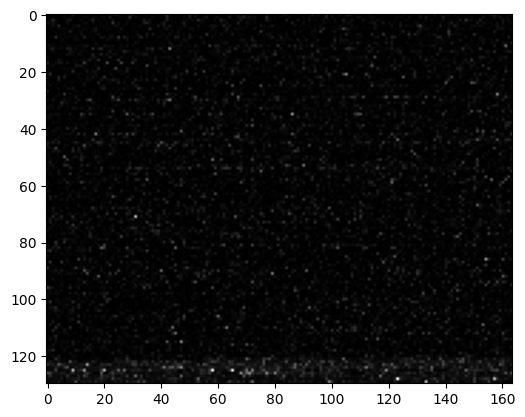

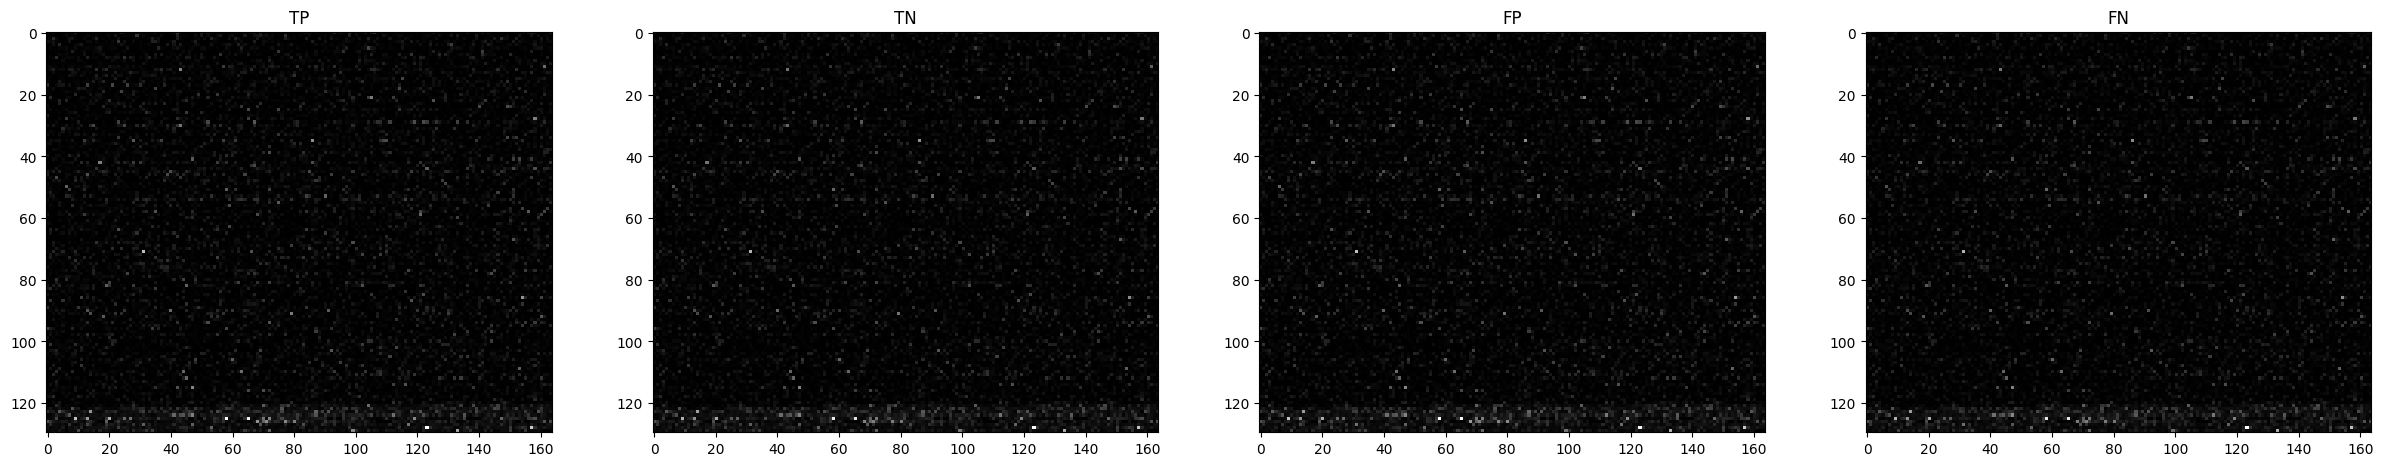

In [ ]:

tp = 0  # label = autism, pred = autism
fp = 0  # label = td, pred = autism
tn = 0  # label = td, pred = td
fn = 0  # label = autism, pred = td
list_tp = ['tp', 'tn', 'fp', 'fn']
list_methods = ['smooth']
dist_average_graph = {}
dist_all_subjects = {}


add_useless = np.zeros(3)
print(add_useless.shape)

for i in list_methods:
  dist_average_graph[i] = {}
  for j in list_tp:
    dist_average_graph[i][j] = np.zeros((130,164))

for ensemble_fold in range(5):
  test_index = dist_ensemble_test[str(ensemble_fold+1)]
  labels = labels_ensemble[str(ensemble_fold+1)]
  test_outputs_ensemble = outputs_ensemble[str(ensemble_fold+1)]['1'] + outputs_ensemble[str(ensemble_fold+1)]['2'] + outputs_ensemble[str(ensemble_fold+1)]['3'] + outputs_ensemble[str(ensemble_fold+1)]['4'] + outputs_ensemble[str(ensemble_fold+1)]['5']
  test_results_binary = np.zeros_like((test_outputs_ensemble))
  test_results_binary[test_outputs_ensemble<2.5] = 0
  test_results_binary[test_outputs_ensemble>=2.5] = 1
  test_accuracy = metrics.accuracy_score(labels, test_results_binary)
  print('There are ',test_results_binary.shape[0], 'subjects in the ensemble fold ', str(ensemble_fold+1))
  print('The accuracy of this ensemble fold is ',test_accuracy)

  for i in range(len(test_index)):
    each_subject = test_index[i]
    each_label_index = labels[i]
    each_output_index = test_results_binary[i]

    print('The subject is: ', each_subject, ' the label is ',each_label_index, ' the prediction is ', each_output_index)

    # plot_vanilla = np.concatenate((all_vanilla[each_subject,:],add_useless), axis = 0)
    # plot_guided = np.concatenate((all_guided[each_subject,:],add_useless), axis = 0)
    plot_smooth = np.concatenate((all_smooth[each_subject,:],add_useless), axis = 0)
    # plot_guidedsmooth = np.concatenate((all_guidedsmooth[each_subject,:],add_useless), axis = 0)


    # plot_vanilla = plot_vanilla.reshape((130,164))
    # plot_guided = plot_guided.reshape((130,164))
    plot_smooth = plot_smooth.reshape((130,164))
    # plot_guidedsmooth = plot_guidedsmooth.reshape((130,164))

    if each_label_index == 0: #autism
      if each_output_index == 0:
        dist_all_subjects[str(each_subject)] = 'tp'
        tp = tp + 1
        dist_average_graph['smooth']['tp'] = dist_average_graph['smooth']['tp'] + plot_smooth
      else:
        fn = fn + 1
        dist_all_subjects[str(each_subject)] = 'fn'
        dist_average_graph['smooth']['fn'] = dist_average_graph['smooth']['fn'] + plot_smooth
    else:   # td
      if each_output_index == 1:
        tn = tn + 1
        dist_all_subjects[str(each_subject)] = 'tn'
        dist_average_graph['smooth']['tn'] = dist_average_graph['smooth']['tn'] + plot_smooth
      else:
        fp = fp + 1
        dist_all_subjects[str(each_subject)] = 'fp'
        dist_average_graph['smooth']['fp'] = dist_average_graph['smooth']['fp'] + plot_smooth

FCN_all_average_smooth = (dist_average_graph['smooth']['tp'] + dist_average_graph['smooth']['fn'] + dist_average_graph['smooth']['tn'] + dist_average_graph['smooth']['fp'])/870
average_smooth_tp = dist_average_graph['smooth']['tp'] / tp
average_smooth_tn = dist_average_graph['smooth']['tn'] / tn
average_smooth_fp = dist_average_graph['smooth']['fp'] / fp
average_smooth_fn = dist_average_graph['smooth']['fn'] / fn

dist_tp = {}
dist_tp['tp'] = tp
dist_tp['tn'] = tn
dist_tp['fp'] = fp
dist_tp['fn'] = fn

plt.imshow(FCN_all_average_smooth, cmap="gray")
plt.show()


plt.figure("check", (30, 6))
plt.subplot(1, 4, 1)
plt.title("TP")
plt.imshow(average_smooth_tp, cmap="gray")
plt.subplot(1, 4, 2)
plt.title("TN")
plt.imshow(average_smooth_tn, cmap="gray")
plt.subplot(1, 4, 3)
plt.title("FP")
plt.imshow(average_smooth_fp, cmap="gray")
plt.subplot(1, 4, 4)
plt.title("FN")
plt.imshow(average_smooth_fn, cmap="gray")
plt.show()




In [ ]:
print(sMRI_feature_names)
print(fMRI_feature_names)
useless_list = [['empty'],['empty'],['empty']]
total_features_list = fMRI_feature_names + sMRI_feature_names + useless_list
print(len(total_features_list))
print(total_features_list)
print(dist_all_subjects)

all_features = np.concatenate((fMRI_images,sMRI_features),axis=1)
print(all_features.shape)
# test = np.array(total_features_list)
# print(test)

[['ctx-lh-bankssts', 'NumVert'], ['ctx-lh-caudalanteriorcingulate', 'NumVert'], ['ctx-lh-caudalmiddlefrontal', 'NumVert'], ['ctx-lh-cuneus', 'NumVert'], ['ctx-lh-entorhinal', 'NumVert'], ['ctx-lh-fusiform', 'NumVert'], ['ctx-lh-inferiorparietal', 'NumVert'], ['ctx-lh-inferiortemporal', 'NumVert'], ['ctx-lh-isthmuscingulate', 'NumVert'], ['ctx-lh-lateraloccipital', 'NumVert'], ['ctx-lh-lateralorbitofrontal', 'NumVert'], ['ctx-lh-lingual', 'NumVert'], ['ctx-lh-medialorbitofrontal', 'NumVert'], ['ctx-lh-middletemporal', 'NumVert'], ['ctx-lh-parahippocampal', 'NumVert'], ['ctx-lh-paracentral', 'NumVert'], ['ctx-lh-parsopercularis', 'NumVert'], ['ctx-lh-parsorbitalis', 'NumVert'], ['ctx-lh-parstriangularis', 'NumVert'], ['ctx-lh-pericalcarine', 'NumVert'], ['ctx-lh-postcentral', 'NumVert'], ['ctx-lh-posteriorcingulate', 'NumVert'], ['ctx-lh-precentral', 'NumVert'], ['ctx-lh-precuneus', 'NumVert'], ['ctx-lh-rostralanteriorcingulate', 'NumVert'], ['ctx-lh-rostralmiddlefrontal', 'NumVert'], ['

Extract the top 99.9% highest intensities, plot these important features

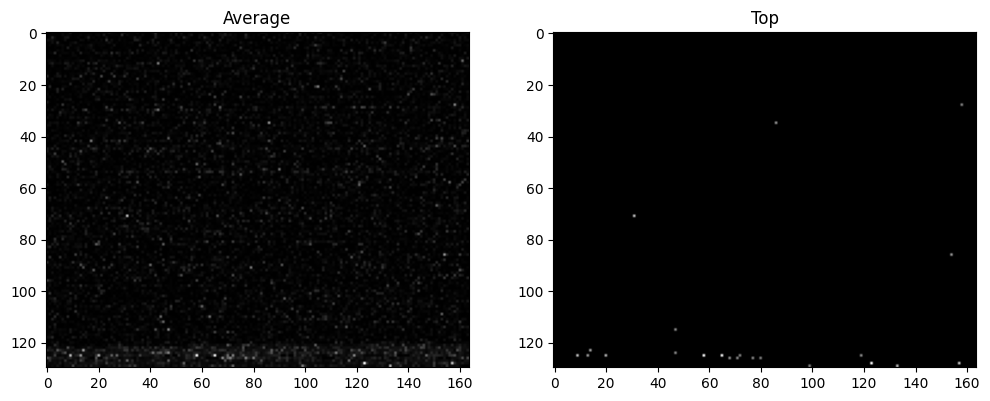

(21320,)
22
[ 4750  5826 11675 14258 18907 20186 20383 20509 20513 20520 20558 20565
 20572 20619 20732 20735 20741 20744 21115 21149 21255 21289]
[39.83562700067791, 38.078734454987725, 36.83274250906645, 30.677022773070263, 29.03652134855654, 29.009148419251847, 26.85942381071919, 26.838010477143886, 24.453384506948506, 23.311303806411722, 22.713939957225417, 22.40301687111602, 21.62266945211198, 21.053822263765454, 20.797947628162945, 20.610568007956616, 20.55276328648335, 20.26455785534962, 19.727002159067844, 19.646948990334447, 19.494358694995537, 19.27348276377215]
No.    Name     saliency
1     ['wm-lh-isthmuscingulate', 'Intensity normMin']     39.83562700067791
2     ['Left-Inf-Lat-Vent', 'Volume']     38.078734454987725
3     ['3rd-Ventricle', 'Volume']     36.83274250906645
4     ['wm-rh-isthmuscingulate', 'Intensity normMin']     30.677022773070263
5     [72, 104]     29.03652134855654
6     ['ctx-rh-temporalpole', 'CurvInd']     29.009148419251847
7     ['3rd-Ventricle', 

In [ ]:
import scipy.stats
# t, pval = scipy.stats.ttest_ind(request_e, request_c)

def find_common_4(index_1,index_2,index_3,index_4, feature_names):
  common_index = []
  feature_name = []
  for index in index_1:
    if index in index_2 & index in index_3 & index in index_4:
      common_index.append(index)
      feature_name.append(feature_names[index])
  return common_index, feature_name

def find_name(index,feature_names):
  names=[]
  for i in index:
    names.append(feature_names[i])
  return names


percentile = 99.9
top_values_smooth = np.percentile(FCN_all_average_smooth, percentile)
top_important_FCN_smooth = np.copy(FCN_all_average_smooth)
top_important_FCN_smooth[top_important_FCN_smooth<top_values_smooth] = 0

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Average")
plt.imshow(FCN_all_average_smooth, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Top")
plt.imshow(top_important_FCN_smooth, cmap="gray")
plt.show()

top_important_FCN_smooth_flatten = top_important_FCN_smooth.flatten()
top_index = np.where(top_important_FCN_smooth_flatten)
print(top_important_FCN_smooth_flatten.shape)
print(len(top_index[0]))
print(top_index[0])

saliency_intensity = top_important_FCN_smooth_flatten[top_important_FCN_smooth_flatten>0]
saliency_intensity = sorted(saliency_intensity, reverse=True)
print(saliency_intensity)

print('No.    Name     saliency')
for i in range(len(top_index[0])):
  each_index = np.where(top_important_FCN_smooth_flatten==saliency_intensity[i])
  each_index = each_index[0][0]
  name = total_features_list[each_index]
  each_intensity = top_important_FCN_smooth_flatten[each_index]
  print(str(i+1),'   ',name,'   ',each_intensity)



In [ ]:

print('No.    Name')
for i in range(len(top_index[0])):
  each_index = np.where(top_important_FCN_smooth_flatten==saliency_intensity[i])
  each_index = each_index[0][0]
  name = total_features_list[each_index]
  each_intensity = top_important_FCN_smooth_flatten[each_index]
  print(str(i+1),'   ',name,'   ')


No.    Name
1     ['wm-lh-isthmuscingulate', 'Intensity normMin']    
2     ['Left-Inf-Lat-Vent', 'Volume']    
3     ['3rd-Ventricle', 'Volume']    
4     ['wm-rh-isthmuscingulate', 'Intensity normMin']    
5     [72, 104]    
6     ['ctx-rh-temporalpole', 'CurvInd']    
7     ['3rd-Ventricle', 'Number of Voxels']    
8     ['wm-rh-isthmuscingulate', 'Intensity normRange']    
9     ['ctx-lh-parahippocampal', 'ThickStd']    
10     ['Left-Inf-Lat-Vent', 'Number of Voxels']    
11     [94, 124]    
12     [32, 155]    
13     ['CC_Posterior', 'Intensity normMin']    
14     ['Left-choroid-plexus', 'Intensity normMean']    
15     [155, 198]    
16     ['ctx-lh-inferiortemporal', 'FoldInd']    
17     ['CC_Mid_Anterior', 'Intensity normMin']    
18     ['Left-Thalamus', 'Intensity normMax']    
19     [26, 102]    
20     ['Left-VentralDC', 'Volume']    
21     ['wm-lh-isthmuscingulate', 'Intensity normRange']    
22     ['Left-Pallidum', 'Intensity normMax']    


Plot the box plot for each important features in four groups (TP, TN, FP, FN)

1     ['wm-lh-isthmuscingulate', 'Intensity normMin']     39.83562700067791
The P-value between TP and TN groups is:  1.1235846561241543e-07


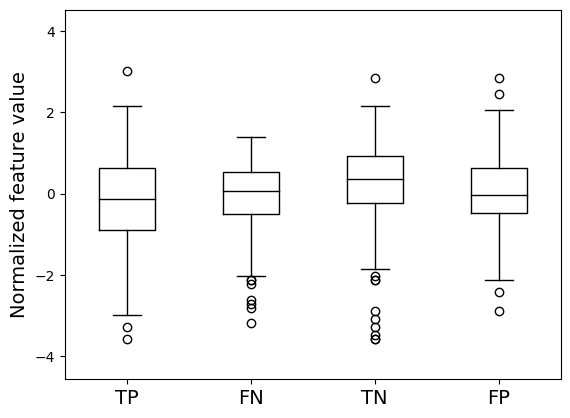

2     ['Left-Inf-Lat-Vent', 'Volume']     38.078734454987725
The P-value between TP and TN groups is:  6.4878027399140526e-06


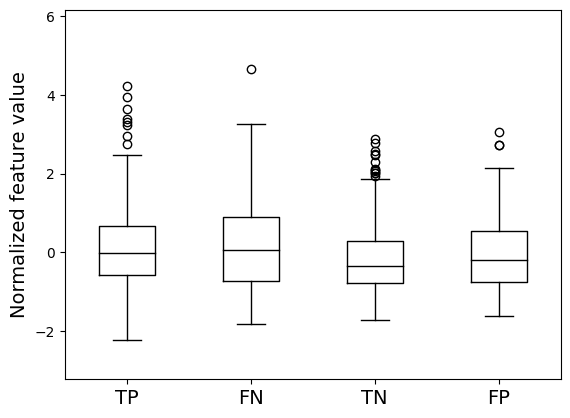

3     ['3rd-Ventricle', 'Volume']     36.83274250906645
The P-value between TP and TN groups is:  1.2301276960215858e-12


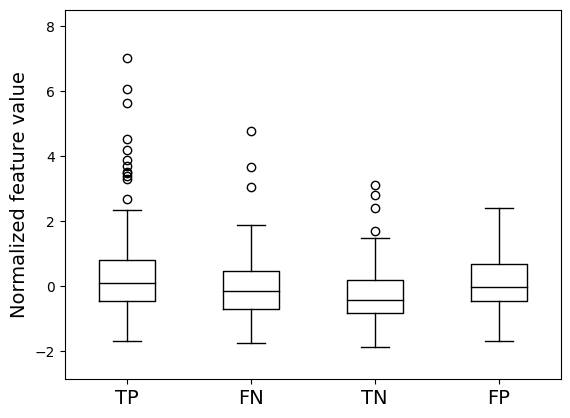

4     ['wm-rh-isthmuscingulate', 'Intensity normMin']     30.677022773070263
The P-value between TP and TN groups is:  1.0467870525792573e-08


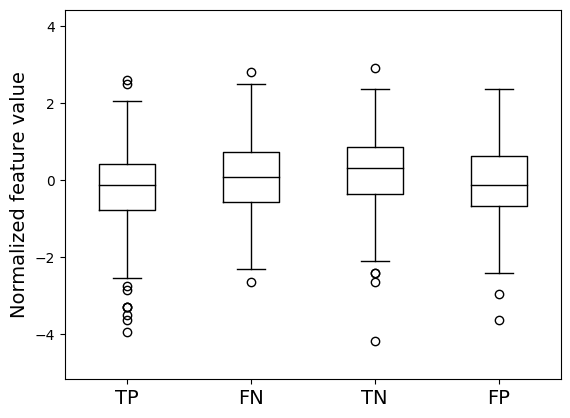

5     [72, 104]     29.03652134855654
The P-value between TP and TN groups is:  2.988375053178099e-14


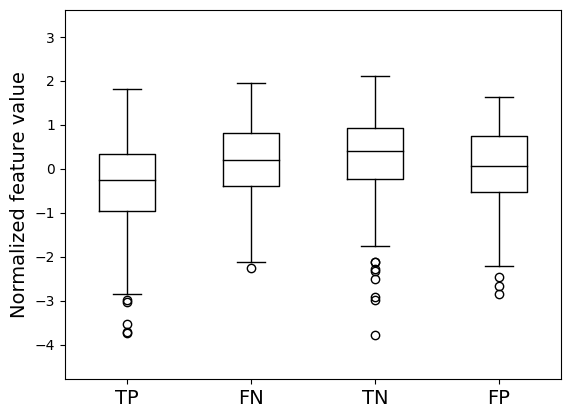

6     ['ctx-rh-temporalpole', 'CurvInd']     29.009148419251847
The P-value between TP and TN groups is:  0.20215535420230968


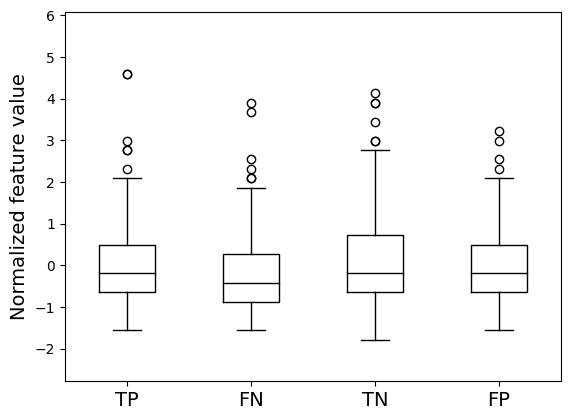

7     ['3rd-Ventricle', 'Number of Voxels']     26.85942381071919
The P-value between TP and TN groups is:  1.4188019766733569e-11


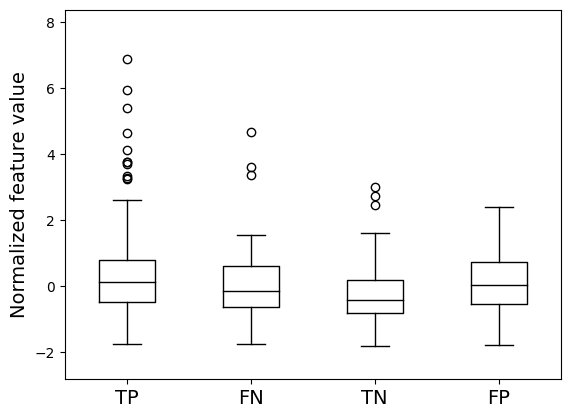

8     ['wm-rh-isthmuscingulate', 'Intensity normRange']     26.838010477143886
The P-value between TP and TN groups is:  5.850073723613022e-11


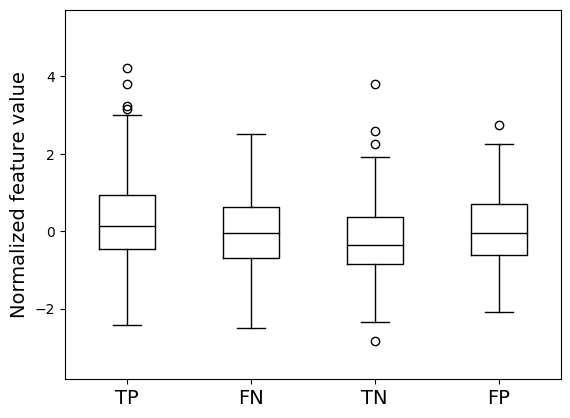

9     ['ctx-lh-parahippocampal', 'ThickStd']     24.453384506948506
The P-value between TP and TN groups is:  0.0925079056250007


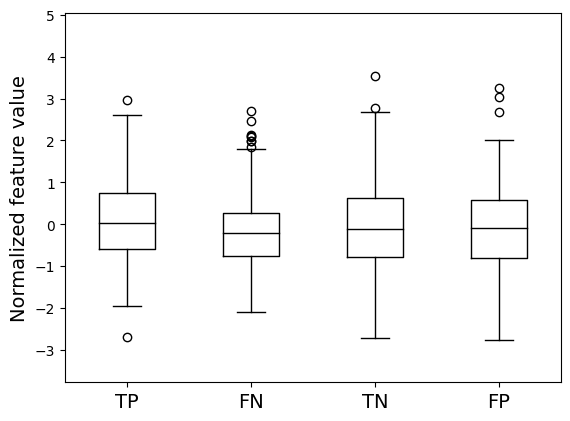

10     ['Left-Inf-Lat-Vent', 'Number of Voxels']     23.311303806411722
The P-value between TP and TN groups is:  1.027475171940522e-05


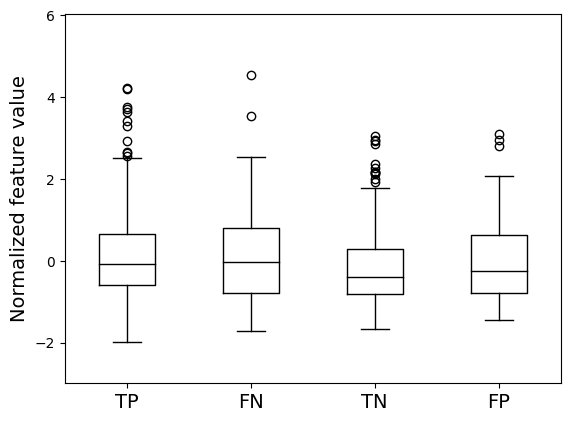

11     [94, 124]     22.713939957225417
The P-value between TP and TN groups is:  2.5597828843825673e-07


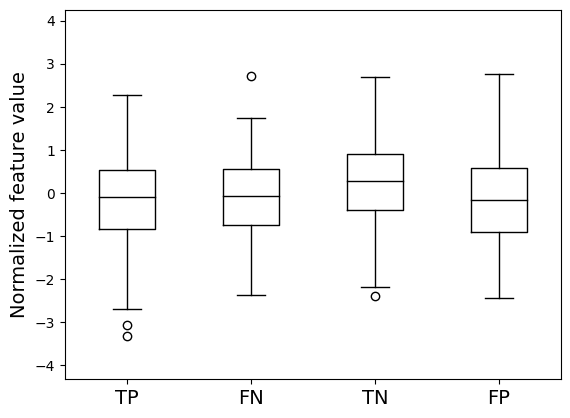

12     [32, 155]     22.40301687111602
The P-value between TP and TN groups is:  0.18847038478320427


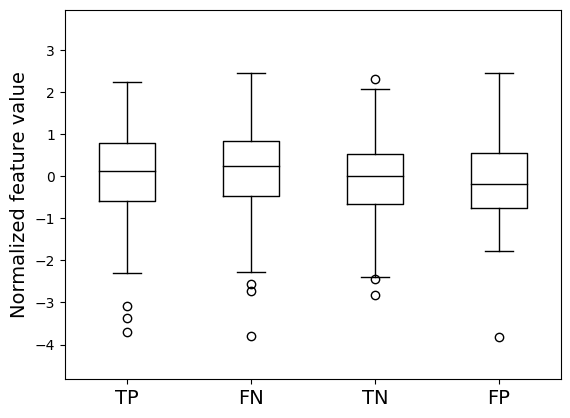

13     ['CC_Posterior', 'Intensity normMin']     21.62266945211198
The P-value between TP and TN groups is:  0.006458875897797939


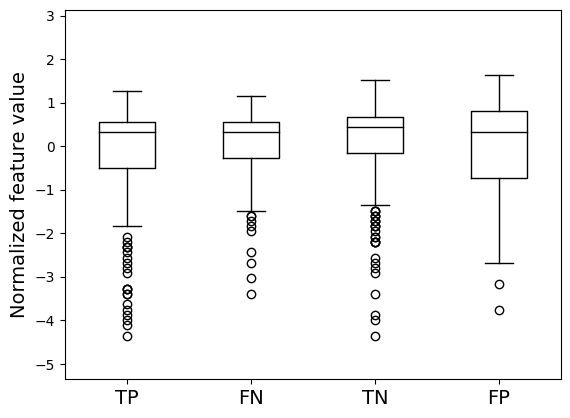

14     ['Left-choroid-plexus', 'Intensity normMean']     21.053822263765454
The P-value between TP and TN groups is:  5.348011517062989e-06


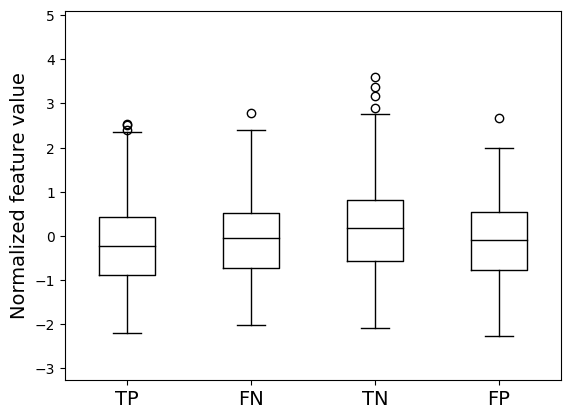

15     [155, 198]     20.797947628162945
The P-value between TP and TN groups is:  0.01085422109476585


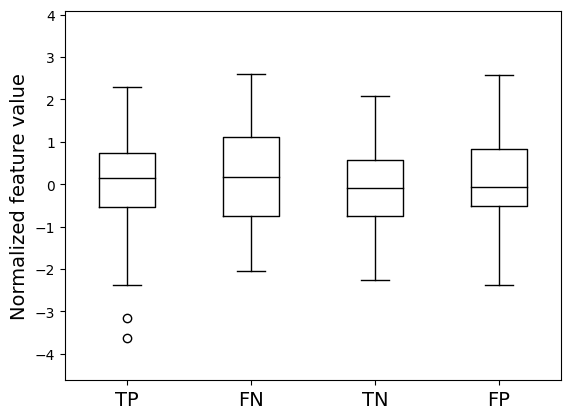

16     ['ctx-lh-inferiortemporal', 'FoldInd']     20.610568007956616
The P-value between TP and TN groups is:  0.36952301512074437


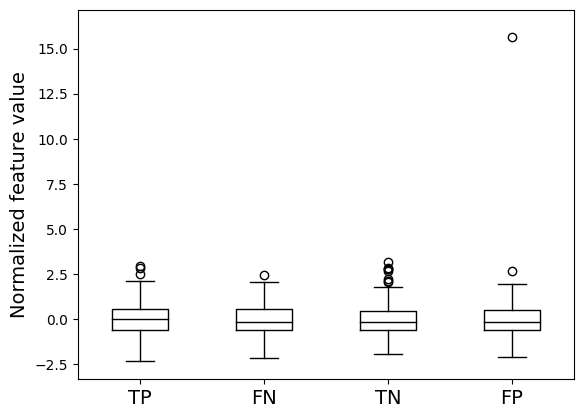

17     ['CC_Mid_Anterior', 'Intensity normMin']     20.55276328648335
The P-value between TP and TN groups is:  0.012534368151671488


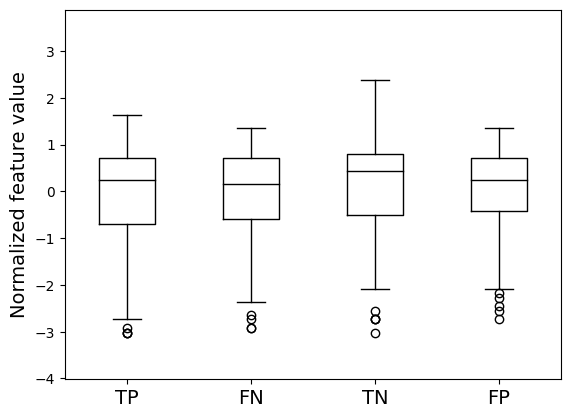

18     ['Left-Thalamus', 'Intensity normMax']     20.26455785534962
The P-value between TP and TN groups is:  0.0037156920836482607


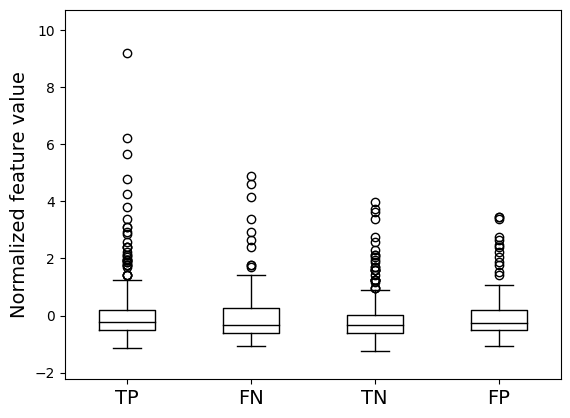

19     [26, 102]     19.727002159067844
The P-value between TP and TN groups is:  2.272760500529911e-06


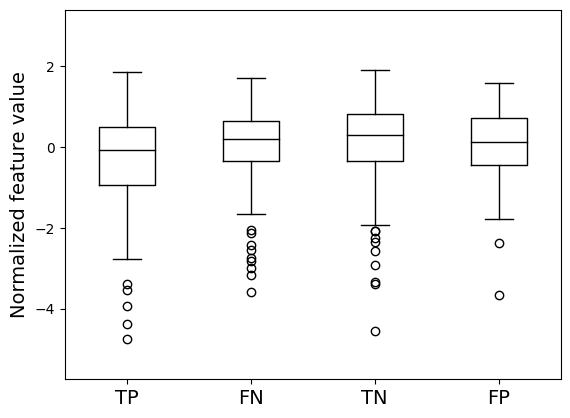

20     ['Left-VentralDC', 'Volume']     19.646948990334447
The P-value between TP and TN groups is:  0.0271950710676996


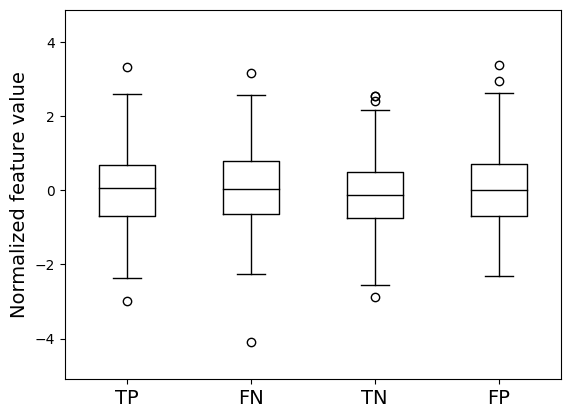

21     ['wm-lh-isthmuscingulate', 'Intensity normRange']     19.494358694995537
The P-value between TP and TN groups is:  3.419248524062249e-09


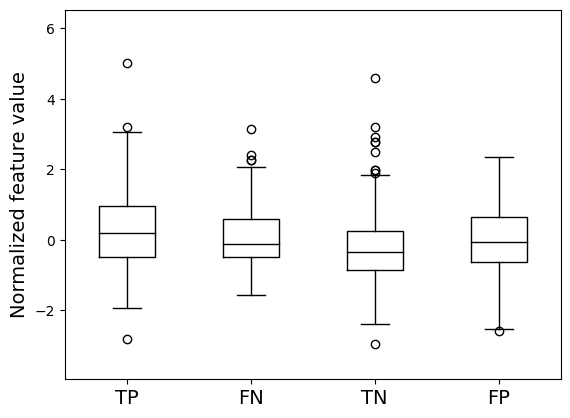

22     ['Left-Pallidum', 'Intensity normMax']     19.27348276377215
The P-value between TP and TN groups is:  0.008376506120032037


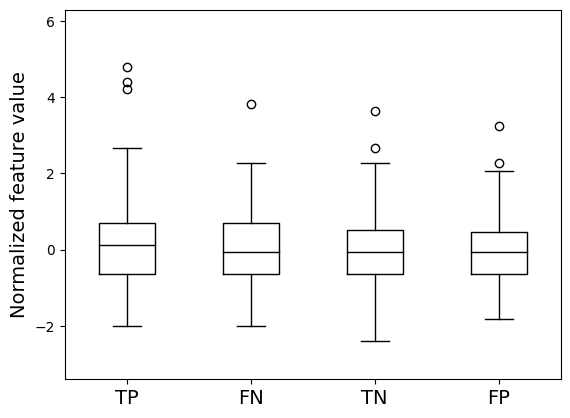

In [ ]:
from scipy import stats

for i in range(len(top_index[0])):
  each_index = np.where(top_important_FCN_smooth_flatten==saliency_intensity[i])
  special_feature_index = each_index[0][0]
  name = total_features_list[special_feature_index]
  each_intensity = top_important_FCN_smooth_flatten[special_feature_index]
  print(str(i+1),'   ',name,'   ',each_intensity)

  tp_group = []
  fp_group = []
  tn_group = []
  fn_group = []

  for j in range(all_features.shape[0]):
    subject_type = dist_all_subjects[str(j)]
    if subject_type == 'tp':
      tp_group.append(all_features[j,special_feature_index])
    if subject_type == 'tn':
      tn_group.append(all_features[j,special_feature_index])
    if subject_type == 'fp':
      fp_group.append(all_features[j,special_feature_index])
    if subject_type == 'fn':
      fn_group.append(all_features[j,special_feature_index])

  t,p = stats.ttest_ind(a=tp_group, b=tn_group, equal_var=True)
  print('The P-value between TP and TN groups is: ',p)
  ################################### box plot #################################################
  ################################### box plot #################################################
  ################################### box plot #################################################

  all_data = [tp_group, fn_group, tn_group, fp_group]
  # print(tp_group)
  # print(fp_group)
  # print(tn_group)
  # print(fn_group)
  four_labels = ['TP', 'FN', 'TN', 'FP']
  plt.boxplot(all_data, vert=True,patch_artist=False,labels=four_labels,medianprops=dict(color="black"))
  plt.ylabel('Normalized feature value',fontsize=14)
  plt.xticks(fontsize=14)
  plt.ylim((min(all_features[:,special_feature_index])-1,max(all_features[:,special_feature_index])+1.5))
  plt.show()


## Create .nii files for functional and structural features, it is the whole brain view

In [ ]:
import nibabel as nib
atlas_path = '/content/drive/MyDrive/ABIDE/plot_atlas/abide_cc200_roi_atlas.nii'
smri_atlas_path = '/content/drive/MyDrive/ABIDE/plot_atlas/desikanKillianyMNI.nii.gz'
cc200 = nib.load(atlas_path)
aff = nib.load(atlas_path).affine
cc200 = np.array(cc200.get_fdata())

dk_atlas = nib.load(smri_atlas_path)
dk_aff = nib.load(smri_atlas_path).affine
dk_atlas = np.array(dk_atlas.get_fdata())


new_fmri_plot = np.copy(cc200)
print(new_fmri_plot.shape)
print(np.unique(new_fmri_plot))
FCN_all_average_smooth_flatten = FCN_all_average_smooth.flatten()
print(FCN_all_average_smooth_flatten.shape)
fmri_all_saliency = FCN_all_average_smooth_flatten[0:19900]
smri_all_saliency = FCN_all_average_smooth_flatten[19900:19900+1417]
print(fmri_all_saliency.shape)
print(len(fMRI_feature_names))
print(smri_all_saliency.shape)
print(len(sMRI_feature_names))


(63, 75, 61)
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194

### Functional brain .nii file

Z-score normalization of the saliency map

[0.27944285 0.34804486 0.84035247 ... 0.0644776  0.69265124 2.46250751]
(19900,)


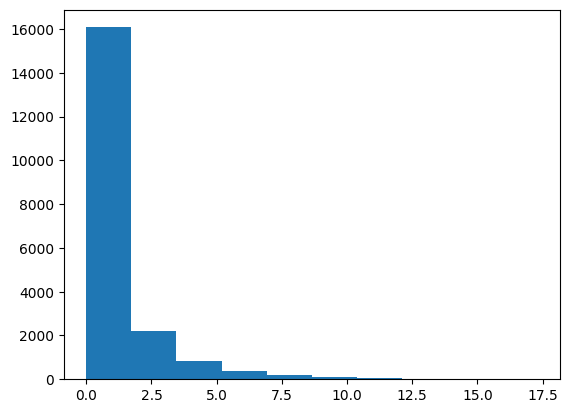

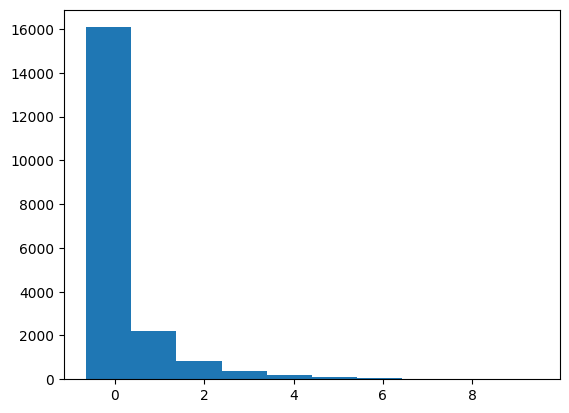

[0.97470197 0.99892708 2.09737235 ... 0.42564678 0.83746654 0.40316667]
(1417,)


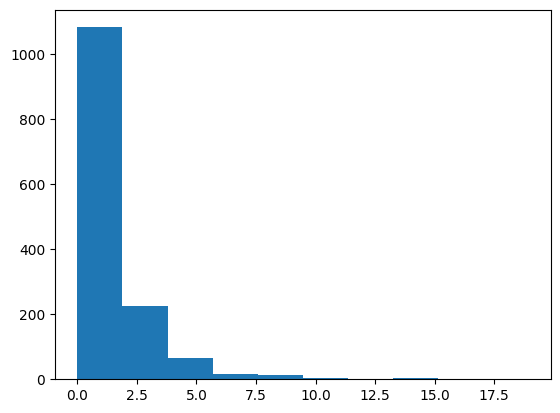

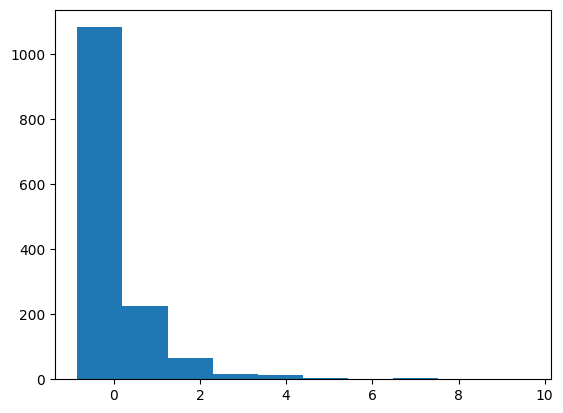

In [ ]:
# print(fmri_all_saliency)
# print(fmri_all_saliency.shape)
# plt.hist(fmri_all_saliency.flatten())
# plt.show()
# z_mean = np.mean(fmri_all_saliency)
# z_std = np.std(fmri_all_saliency)
# fmri_all_saliency = (fmri_all_saliency - z_mean) / z_std
# plt.hist(fmri_all_saliency.flatten())
# plt.show()


# print(smri_all_saliency)
# print(smri_all_saliency.shape)
# plt.hist(smri_all_saliency.flatten())
# plt.show()
# z_mean = np.mean(smri_all_saliency)
# z_std = np.std(smri_all_saliency)
# smri_all_saliency = (smri_all_saliency - z_mean) / z_std
# plt.hist(smri_all_saliency.flatten())
# plt.show()

{'1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0, '10': 0, '11': 0, '12': 0, '13': 0, '14': 0, '15': 0, '16': 0, '17': 0, '18': 0, '19': 0, '20': 0, '21': 0, '22': 0, '23': 0, '24': 0, '25': 0, '26': 0, '27': 0, '28': 0, '29': 0, '30': 0, '31': 0, '32': 0, '33': 0, '34': 0, '35': 0, '36': 0, '37': 0, '38': 0, '39': 0, '40': 0, '41': 0, '42': 0, '43': 0, '44': 0, '45': 0, '46': 0, '47': 0, '48': 0, '49': 0, '50': 0, '51': 0, '52': 0, '53': 0, '54': 0, '55': 0, '56': 0, '57': 0, '58': 0, '59': 0, '60': 0, '61': 0, '62': 0, '63': 0, '64': 0, '65': 0, '66': 0, '67': 0, '68': 0, '69': 0, '70': 0, '71': 0, '72': 0, '73': 0, '74': 0, '75': 0, '76': 0, '77': 0, '78': 0, '79': 0, '80': 0, '81': 0, '82': 0, '83': 0, '84': 0, '85': 0, '86': 0, '87': 0, '88': 0, '89': 0, '90': 0, '91': 0, '92': 0, '93': 0, '94': 0, '95': 0, '96': 0, '97': 0, '98': 0, '99': 0, '100': 0, '101': 0, '102': 0, '103': 0, '104': 0, '105': 0, '106': 0, '107': 0, '108': 0, '109': 0, '110': 0, '111': 

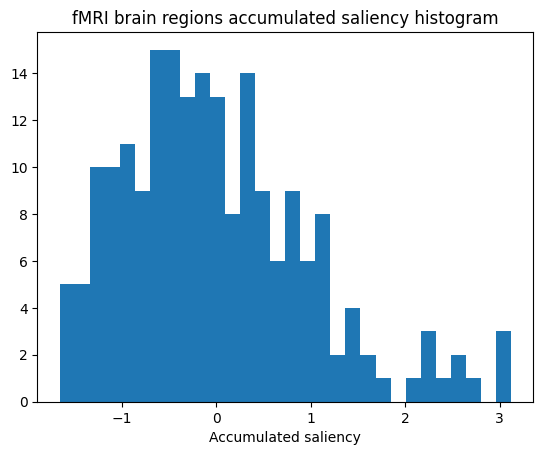

[-1.6572104848154476, -1.608133157838824, -1.5885605671332486, -1.5727599464645976, -1.5209949514887393, -1.48007534438811, -1.4564917084065363, -1.367740409973209, -1.364814996120327, -1.339201623512225, -1.3323190581028652, -1.3258767709913957, -1.3189860197367091, -1.3101589341181117, -1.2979728668312722, -1.2754405877453583, -1.254822280355473, -1.2426889352472936, -1.213733414202026, -1.1885397381738956, -1.1772536388860164, -1.1702383951772135, -1.1674801297368185, -1.1389643894441785, -1.0838656701310507, -1.0801094339477324, -1.0751472588217448, -1.0738420036636869, -1.06732505376465, -1.0277446297412225, -1.0174256527818049, -1.0081565884085124, -0.9765605409166735, -0.9588632204796935, -0.9443184112317183, -0.939828565420764, -0.9127690569708797, -0.9076724816736257, -0.906687959907543, -0.8794798290274356, -0.8719985421755636, -0.8553878231650613, -0.8542578876351188, -0.8291528240558091, -0.8012135431434015, -0.7996058580645257, -0.7489420692402772, -0.7472400666371938, -0.

In [ ]:

new_cc200_mapping = {}
for i in range(1,img.shape[0]+1):
  new_cc200_mapping[str(i)] = 0
print(new_cc200_mapping)
for i in range(fmri_all_saliency.shape[0]):
  each_saliency = fmri_all_saliency[i]
  fmri_each_feature_name = fMRI_feature_names[i]
  region_1 = fmri_each_feature_name[0]
  region_2 = fmri_each_feature_name[1]
  new_cc200_mapping[str(region_1)] = new_cc200_mapping[str(region_1)] + each_saliency
  new_cc200_mapping[str(region_2)] = new_cc200_mapping[str(region_2)] + each_saliency
print(new_cc200_mapping)
values = list(new_cc200_mapping.values())
mean_values = np.mean(np.array(values))
std_values = np.std(np.array(values))
print(mean_values)
print(std_values)

for i in range(1,200+1):
  new_cc200_mapping[str(i)] = (new_cc200_mapping[str(i)] - mean_values) / std_values

print(new_cc200_mapping)
values = list(new_cc200_mapping.values())

print(values)
plt.hist(values,bins=30)
plt.title('fMRI brain regions accumulated saliency histogram')
plt.xlabel('Accumulated saliency')
plt.show()

values = np.array(values)
values = sorted(values)
print(values)


Brain region  intensity
160      3.1174958581798715
27      3.0833105778999825
52      3.0585883641112255
155      2.7381658291260758
42      2.5651202872943113
39      2.4850281748924847
130      2.46452893550469
140      2.296446232406097
86      2.240464857802848
124      2.2001023708412712
32      2.1051852343538533
94      1.8152360281097237
43      1.6739145765644476
99      1.5824365394972293
195      1.4965787449955557
198      1.4953384978674364
78      1.424522127812355
68      1.4078061177983108
101      1.2558411109061103
194      1.20929673429725
87      1.2026595235411595
102      1.1515983217043877
51      1.12910318880779
57      1.1149178338176893
199      1.1130534905192848
122      1.0953208671432753
72      1.0924309579803395
141      1.081905555826508
109      1.0412425574042754
135      1.0260155831218045
71      1.0040025874362648
187      0.9478116645038079
148      0.9214557050212011
11      0.9100176100151721
188      0.8811959136181634
174      0.872905845455

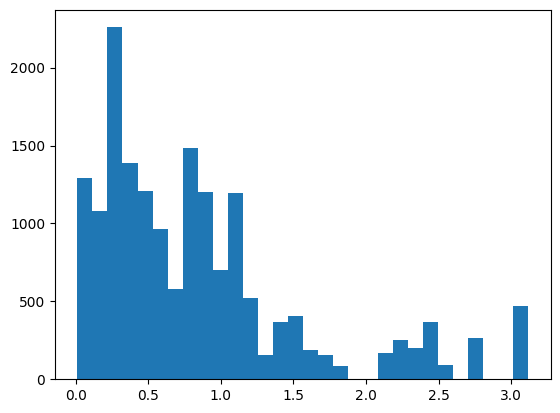

In [ ]:
new_save_fmri_saliency_atlas = np.zeros_like(cc200)
# print('brain region  intensity')
for i in range(1,img.shape[0]+1):
  value = new_cc200_mapping[str(i)]
  each_index = values.index(value)
  new_save_fmri_saliency_atlas[cc200==i] = value
  # print(i,'    ',value)

unsorted_values = list(new_cc200_mapping.values())
values = sorted(values,reverse=True)
print('Brain region  intensity')
for i in range(len(values)):
  value = values[i]
  each_index = unsorted_values.index(value)
  print(each_index+1,'    ',value)


print(new_save_fmri_saliency_atlas[new_save_fmri_saliency_atlas>0])
plt.hist(new_save_fmri_saliency_atlas[new_save_fmri_saliency_atlas>0].flatten(),bins=30)
plt.show()
new_save_fmri_saliency_atlas_ = nib.Nifti1Image(new_save_fmri_saliency_atlas, aff)
nib.save(new_save_fmri_saliency_atlas_, '/content/drive/MyDrive/ABIDE/plot_atlas/aefcn/abide_cc200_saliency.nii')

(63, 75, 61)
(63, 75, 61)


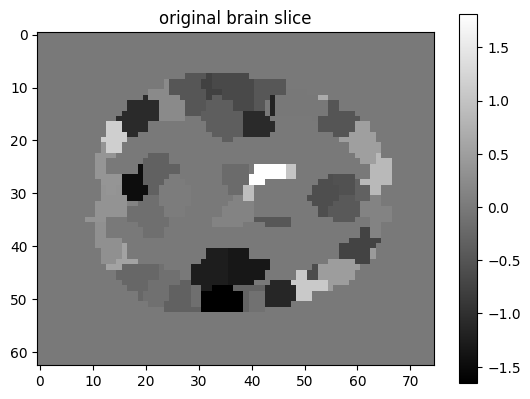

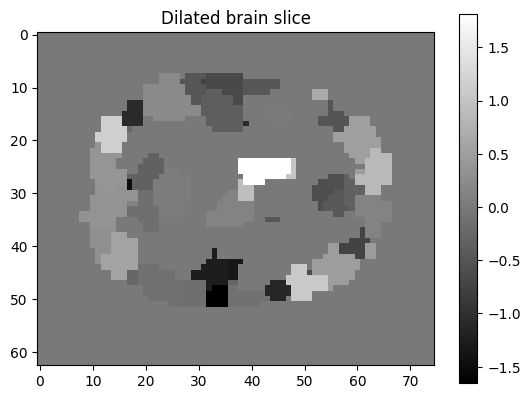

In [ ]:
from scipy.ndimage import grey_dilation
zoom_fmri_saliency_map = np.copy(new_save_fmri_saliency_atlas)
print(new_save_fmri_saliency_atlas.shape)

# 执行膨胀操作
size = (2, 2, 2)  # 根据需要调整膨胀的大小
zoom_fmri_saliency_map = grey_dilation(zoom_fmri_saliency_map, size=size, mode='nearest')
print(zoom_fmri_saliency_map.shape)

plt.imshow(new_save_fmri_saliency_atlas[:, :, new_save_fmri_saliency_atlas.shape[2]//2], cmap='gray')
plt.title('original brain slice')
plt.colorbar()
plt.show()

plt.imshow(zoom_fmri_saliency_map[:, :, zoom_fmri_saliency_map.shape[2]//2], cmap='gray')
plt.title('Dilated brain slice')
plt.colorbar()
plt.show()

zoom_fmri_saliency_map = nib.Nifti1Image(zoom_fmri_saliency_map, aff)
nib.save(zoom_fmri_saliency_map, '/content/drive/MyDrive/ABIDE/plot_atlas/aefcn/abide_cc200_saliency_dilation2.nii')

(63, 75, 61)
(63, 75, 61)


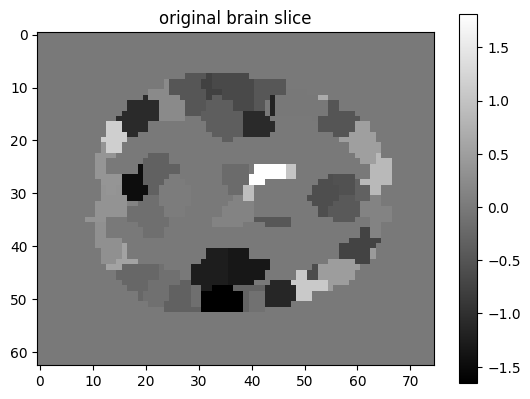

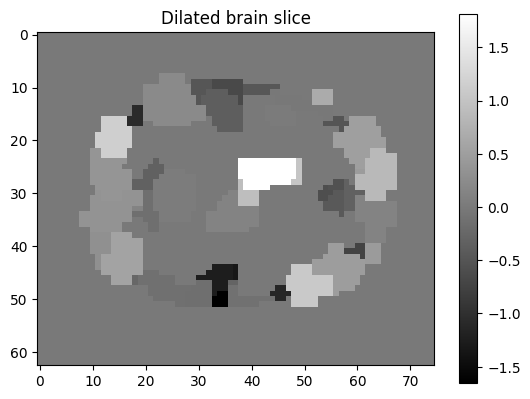

In [ ]:
from scipy.ndimage import grey_dilation
zoom_fmri_saliency_map = np.copy(new_save_fmri_saliency_atlas)
print(new_save_fmri_saliency_atlas.shape)

# 执行膨胀操作
size = (3, 3, 3)  # 根据需要调整膨胀的大小
zoom_fmri_saliency_map = grey_dilation(zoom_fmri_saliency_map, size=size, mode='nearest')
print(zoom_fmri_saliency_map.shape)

plt.imshow(new_save_fmri_saliency_atlas[:, :, new_save_fmri_saliency_atlas.shape[2]//2], cmap='gray')
plt.title('original brain slice')
plt.colorbar()
plt.show()

plt.imshow(zoom_fmri_saliency_map[:, :, zoom_fmri_saliency_map.shape[2]//2], cmap='gray')
plt.title('Dilated brain slice')
plt.colorbar()
plt.show()

zoom_fmri_saliency_map = nib.Nifti1Image(zoom_fmri_saliency_map, aff)
nib.save(zoom_fmri_saliency_map, '/content/drive/MyDrive/ABIDE/plot_atlas/aefcn/abide_cc200_saliency_dilation3.nii')

(63, 75, 61)
(63, 75, 61)


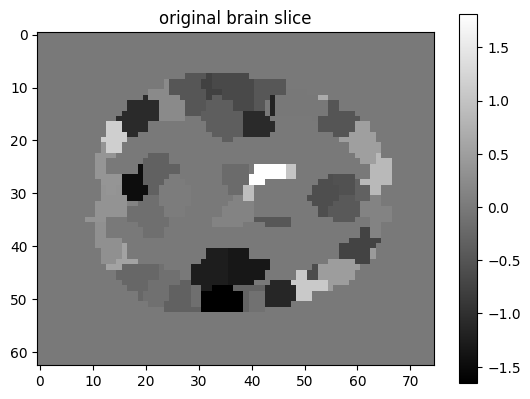

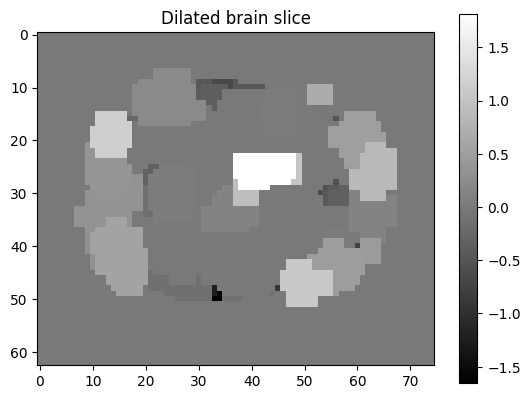

In [ ]:
from scipy.ndimage import grey_dilation
zoom_fmri_saliency_map = np.copy(new_save_fmri_saliency_atlas)
print(new_save_fmri_saliency_atlas.shape)

# 执行膨胀操作
size = (4, 4, 4)  # 根据需要调整膨胀的大小
zoom_fmri_saliency_map = grey_dilation(zoom_fmri_saliency_map, size=size, mode='nearest')
print(zoom_fmri_saliency_map.shape)

plt.imshow(new_save_fmri_saliency_atlas[:, :, new_save_fmri_saliency_atlas.shape[2]//2], cmap='gray')
plt.title('original brain slice')
plt.colorbar()
plt.show()

plt.imshow(zoom_fmri_saliency_map[:, :, zoom_fmri_saliency_map.shape[2]//2], cmap='gray')
plt.title('Dilated brain slice')
plt.colorbar()
plt.show()

zoom_fmri_saliency_map = nib.Nifti1Image(zoom_fmri_saliency_map, aff)
nib.save(zoom_fmri_saliency_map, '/content/drive/MyDrive/ABIDE/plot_atlas/aefcn/abide_cc200_saliency_dilation4.nii')

(63, 75, 61)
(63, 75, 61)


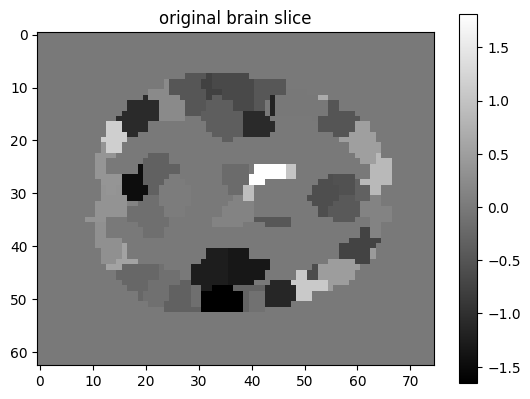

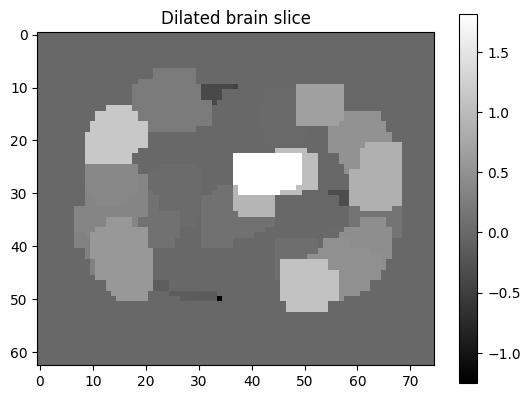

In [ ]:
from scipy.ndimage import grey_dilation
zoom_fmri_saliency_map = np.copy(new_save_fmri_saliency_atlas)
print(new_save_fmri_saliency_atlas.shape)

# 执行膨胀操作
size = (5, 5, 5)  # 根据需要调整膨胀的大小
zoom_fmri_saliency_map = grey_dilation(zoom_fmri_saliency_map, size=size, mode='nearest')
print(zoom_fmri_saliency_map.shape)

plt.imshow(new_save_fmri_saliency_atlas[:, :, new_save_fmri_saliency_atlas.shape[2]//2], cmap='gray')
plt.title('original brain slice')
plt.colorbar()
plt.show()

plt.imshow(zoom_fmri_saliency_map[:, :, zoom_fmri_saliency_map.shape[2]//2], cmap='gray')
plt.title('Dilated brain slice')
plt.colorbar()
plt.show()

zoom_fmri_saliency_map = nib.Nifti1Image(zoom_fmri_saliency_map, aff)
nib.save(zoom_fmri_saliency_map, '/content/drive/MyDrive/ABIDE/plot_atlas/aefcn/abide_cc200_saliency_dilation5.nii')

### The function connections plot

In [ ]:
print(fmri_all_saliency.shape)
rank_fmri = np.copy(fmri_all_saliency)
fmri_all_saliency_copy = np.copy(fmri_all_saliency)
mean_rank = np.mean(rank_fmri)
std_rank = np.std(rank_fmri)
rank_fmri = (rank_fmri-mean_rank)/std_rank
fmri_all_saliency_copy = (fmri_all_saliency_copy-mean_rank)/std_rank
rank_fmri = sorted(rank_fmri,reverse=True)
print(rank_fmri[0:200])


(19900,)
[17.448116128808536, 13.518657027624597, 13.325419570506856, 12.327875441869782, 11.662287106988503, 11.325912241251837, 11.243521419839086, 11.033871098409824, 10.744271674238282, 10.115765282676582, 9.869542974380764, 9.795672039813867, 9.351425574991456, 9.339756077566879, 9.192740578347934, 9.136127862382246, 9.033368487801324, 8.944059560911365, 8.92895682405944, 8.584520532582912, 8.536995660545646, 8.430945555606066, 8.388096746427705, 8.380131997601419, 8.143817486256962, 8.026138710073164, 7.964981805339379, 7.8698905986541225, 7.822347814903702, 7.803305268092627, 7.733073737846512, 7.646800034561968, 7.5665179048132485, 7.353055894215659, 7.192449025220565, 7.184581026209878, 7.179838988711066, 7.06581978489439, 7.059193331851475, 7.045874547374659, 6.998841564867005, 6.995055676001546, 6.964538955127575, 6.877647578169042, 6.84827809007962, 6.837465881329653, 6.734906972703512, 6.718712798741632, 6.704248252522432, 6.702297818768981, 6.6986855831978325, 6.682831410

prepare node file

In [ ]:
import csv
edge_node_path = '/content/drive/MyDrive/ABIDE/plot_atlas/'
cc_cordinate_file = 'abide_CC200_ROI_labels.csv'
cc_node_file = 'cc200_node.txt'
cc_node_path = edge_node_path + cc_node_file

!touch /content/drive/MyDrive/ABIDE/plot_atlas/cc200_node.txt

cc_brain_region_names_list=[]
cc_brain_region_coo_list=[]

with open(edge_node_path+cc_cordinate_file, 'r') as file:
    # 创建一个 CSV 读取器对象
    csv_reader = csv.reader(file)

    # 逐行读取 CSV 文件内容
    print(csv_reader)
    for row in csv_reader:
      cc_brain_region_coo_list.append(row[2])
      cc_brain_region_names_list.append(row[4])

print(cc_brain_region_coo_list)
print(cc_brain_region_names_list)
cc_brain_region_coo_list.remove(' center of mass')
cc_brain_region_names_list.remove('AAL')
print(cc_brain_region_coo_list)
print(cc_brain_region_names_list)

for i in range(len(cc_brain_region_coo_list)):
  coor = cc_brain_region_coo_list[i]
  for j in range(len(coor)):
    if coor[j] == '(':
      first_index = int(j + 1)
    if coor[j] == ')':
      second_index = int(j)
  cc_brain_region_coo_list[i] = coor[first_index:second_index]

print(cc_brain_region_coo_list)

for i in range(len(cc_brain_region_coo_list)):
  coor = cc_brain_region_coo_list[i]
  index_=[]
  for j in range(len(coor)):
    if coor[j] == ';':
      index_.append(j)
  cc_brain_region_coo_list[i] = [round(np.float32(coor[0:index_[0]]),1), round(np.float32(coor[index_[0]+1: index_[1]]),1), round(np.float32(coor[index_[1]+1:]),1)]



with open(cc_node_path, 'w') as file:
  for i in range(len(cc_brain_region_coo_list)):
    coor = cc_brain_region_coo_list[i]
    file.writelines(str(coor[0]))
    file.writelines(' ')
    file.writelines(str(coor[1]))
    file.writelines(' ')
    file.writelines(str(coor[2]))
    file.writelines(' ')
    file.writelines(str(1))
    file.writelines(' ')
    file.writelines(str(1))
    file.writelines(' ')
    file.writelines(str(i+1))
    file.writelines('\n')

# with open(test, 'r') as file:
#     # 读取文件内容
#   lines  = file.readlines()

# for i in range(2,77126):
#   current_line = lines[i].split()
#   current_line = [np.float32(num)*template_ratio_cc for num in current_line]
#   lines[i] = ' '.join(map(str, current_line)) + '\n'
#   print(lines[i])

# with open(test, 'w') as file:
#     file.writelines(lines)
# /content/drive/MyDrive/ABIDE/plot_atlas/cc200_node.node

[' center of mass', ' (-39.6;-85.4;1.4)', ' (-49.7;-60.8;23.2)', ' (13.3;-64.4;24.0)', ' (-36.6;-13.9;-2.3)', ' (-6.8;45.7;7.8)', ' (9.1;-35.9;47.1)', ' (55.2;-47.5;41.9)', ' (-40.7;-21.3;54.3)', ' (-19.3;-62.1;-26.1)', ' (43.3;-55.2;-32.2)', ' (-58.9;-30.2;-2.4)', ' (27.7;58.2;-1.6)', ' (2.8;12.4;49.4)', ' (53.8;-55.4;23.5)', ' (13.5;12.3;-7.0)', ' (-49.1;-65.4;-4.3)', ' (46.0;9.1;32.1)', ' (11.6;-20.0;9.5)', ' (-9.9;-67.4;22.4)', ' (-32.7;19.7;2.0)', ' (-8.8;-38.0;69.3)', ' (6.7;42.6;6.1)', ' (-42.1;41.2;13.3)', ' (-58.1;-26.9;16.0)', ' (44.5;40.7;14.5)', ' (43.2;-73.6;-10.9)', ' (-30.5;-5.1;-32.6)', ' (30.4;-33.7;63.4)', ' (1.6;-16.5;34.8)', ' (2.9;-28.0;-36.0)', ' (29.7;-54.6;59.7)', ' (43.5;9.9;-36.2)', ' (-56.5;-43.3;26.5)', ' (-45.6;8.0;31.7)', ' (41.0;-4.7;10.8)', ' (-40.1;-52.6;-33.2)', ' (-13.4;-32.3;0.8)', ' (42.4;23.8;37.6)', ' (62.9;-43.0;-7.8)', ' (1.6;33.3;24.3)', ' (30.1;-39.3;-31.6)', ' (-28.3;50.7;-11.6)', ' (-38.9;5.7;-39.4)', ' (13.5;-94.4;2.2)', ' (-8.2;-17.9;10.6)

prepare connection file

In [ ]:
import csv
edge_node_path = '/content/drive/MyDrive/ABIDE/plot_atlas/aefcn/'
cc_cordinate_file = 'abide_CC200_ROI_labels.csv'
cc_node_file = 'cc200_weighted_connections_100.txt'
cc_node_path = edge_node_path + cc_node_file
cc_number = 200
cc_important_connection_number = 100
connection_map = np.zeros((cc_number,cc_number))

!touch /content/drive/MyDrive/ABIDE/plot_atlas/cc200_weighted_connections_100.txt

print('Brain regions     z-score saliency')
for i in range(cc_important_connection_number):
  saliency_value = rank_fmri[i]
  # print(saliency_value)
  index_ = np.where(fmri_all_saliency_copy==saliency_value)
  # print(index_)
  index_ = index_[0][0]
  # print(index_)
  brain_region_1 = fMRI_feature_names[index_][0]
  brain_region_2 = fMRI_feature_names[index_][1]
  connection_map[brain_region_1, brain_region_2] = saliency_value + 0
  connection_map[brain_region_2, brain_region_1] = saliency_value + 0
  print(brain_region_1, ' ',brain_region_2, '   ',saliency_value)



with open(cc_node_path, 'w') as file:
  for i in range(cc_number):
    for j in range(cc_number):
      file.writelines(str(connection_map[i][j]))
      file.writelines(' ')
    file.writelines('\n')







# cc_brain_region_names_list=[]
# cc_brain_region_coo_list=[]

# with open(edge_node_path+cc_cordinate_file, 'r') as file:
#     # 创建一个 CSV 读取器对象
#     csv_reader = csv.reader(file)

#     # 逐行读取 CSV 文件内容
#     print(csv_reader)
#     for row in csv_reader:
#       cc_brain_region_coo_list.append(row[2])
#       cc_brain_region_names_list.append(row[4])

# print(cc_brain_region_coo_list)
# print(cc_brain_region_names_list)
# cc_brain_region_coo_list.remove(' center of mass')
# cc_brain_region_names_list.remove('AAL')
# print(cc_brain_region_coo_list)
# print(cc_brain_region_names_list)

# for i in range(len(cc_brain_region_coo_list)):
#   coor = cc_brain_region_coo_list[i]
#   for j in range(len(coor)):
#     if coor[j] == '(':
#       first_index = int(j + 1)
#     if coor[j] == ')':
#       second_index = int(j)
#   cc_brain_region_coo_list[i] = coor[first_index:second_index]

# print(cc_brain_region_coo_list)

# for i in range(len(cc_brain_region_coo_list)):
#   coor = cc_brain_region_coo_list[i]
#   index_=[]
#   for j in range(len(coor)):
#     if coor[j] == ';':
#       index_.append(j)
#   cc_brain_region_coo_list[i] = [round(np.float32(coor[0:index_[0]]),1), round(np.float32(coor[index_[0]+1: index_[1]]),1), round(np.float32(coor[index_[1]+1:]),1)]



# with open(cc_node_path, 'w') as file:
#   for i in range(len(cc_brain_region_coo_list)):
#     coor = cc_brain_region_coo_list[i]
#     file.writelines(str(coor[0]))
#     file.writelines(' ')
#     file.writelines(str(coor[1]))
#     file.writelines(' ')
#     file.writelines(str(coor[2]))
#     file.writelines(' ')
#     file.writelines(str(1))
#     file.writelines(' ')
#     file.writelines(str(1))
#     file.writelines(' ')
#     file.writelines(str(i+1))
#     file.writelines('\n')


Brain regions     z-score saliency
72   104     17.448116128808536
94   124     13.518657027624597
32   155     13.325419570506856
155   198     12.327875441869782
26   102     11.662287106988503
19   140     11.325912241251837
11   78     11.243521419839086
39   86     11.033871098409824
101   155     10.744271674238282
27   142     10.115765282676582
140   174     9.869542974380764
51   109     9.795672039813867
99   151     9.351425574991456
140   155     9.339756077566879
145   199     9.192740578347934
11   32     9.136127862382246
48   199     9.033368487801324
130   160     8.944059560911365
58   109     8.92895682405944
139   160     8.584520532582912
42   43     8.536995660545646
87   96     8.430945555606066
87   122     8.388096746427705
57   122     8.380131997601419
47   135     8.143817486256962
26   175     8.026138710073164
68   86     7.964981805339379
102   160     7.8698905986541225
32   97     7.822347814903702
38   113     7.803305268092627
124   135     7.73307373

In [ ]:
print(cc_brain_region_names_list)
cleaned_brain_names = [item.replace('"', '').replace('][',', ').replace('[', '').replace(']', '') for item in cc_brain_region_names_list]

print(cleaned_brain_names)
excel_cc200_brain_names = {}
for i in range(200):
  excel_cc200_brain_names[str(i+1)] = cleaned_brain_names[i]
print(excel_cc200_brain_names)




['["Occipital_Mid_L": 0.81]["Occipital_Inf_L": 0.19]', '["Angular_L": 0.49]["Temporal_Mid_L": 0.45]', '["Precuneus_R": 0.47]["Cuneus_R": 0.31]["Calcarine_R": 0.22]', '["Temporal_Sup_L": 0.33]["Putamen_L": 0.28]["Insula_L": 0.25]', '["Cingulum_Ant_L": 0.66]["Frontal_Sup_Medial_L": 0.28]', '["Cingulum_Mid_R": 0.60]["Precuneus_R": 0.21]', '["Parietal_Inf_R": 0.41]["SupraMarginal_R": 0.41]["Angular_R": 0.18]', '["Postcentral_L": 0.69]["Precentral_L": 0.30]', '["Cerebelum_6_L": 0.75]["Cerebelum_Crus1_L": 0.14]', '["Cerebelum_Crus1_R": 0.77]["Cerebelum_6_R": 0.11]', '["Temporal_Mid_L": 0.96]', '["Frontal_Sup_R": 0.29]["Frontal_Mid_Orb_R": 0.29]["Frontal_Mid_R": 0.23]["Frontal_Sup_Orb_R": 0.19]', '["Supp_Motor_Area_L": 0.39]["Supp_Motor_Area_R": 0.37]["Cingulum_Mid_R": 0.22]', '["Angular_R": 0.46]["Temporal_Mid_R": 0.36]', '["Caudate_R": 0.39]["Olfactory_R": 0.20]["Putamen_R": 0.16]["Rectus_R": 0.13]', '["Temporal_Mid_L": 0.39]["Occipital_Inf_L": 0.31]["Temporal_Inf_L": 0.20]', '["Frontal_Inf

In [ ]:
from openpyxl import Workbook

# 创建一个工作簿
wb = Workbook()

# 选择默认的活动工作表
ws = wb.active

# 添加数据到单元格
ws['A1'] = 'The top 100 connections'
ws['B1'] = 'Brain region in CC200 atlas'
ws['C1'] = 'The corresponding brain regions in AAL atlas'
# ws['A2'] = '张三'
# ws['B2'] = 25
# ws['A3'] = '李四'
# ws['B3'] = 30

for i in range(200):
  row = (i+1)*2
  number_name = "A" + str(row)
  brain_region_1_name = "B" + str(row)
  brain_region_2_name = "B" + str(row+1)
  corresponding_brain_region_1_name = "C" +str(row)
  corresponding_brain_region_2_name = "C" +str(row+1)

  ws[number_name] = str(i+1)

  saliency_value = rank_fmri[i]
  # print(saliency_value)
  index_ = np.where(fmri_all_saliency_copy==saliency_value)
  # print(index_)
  index_ = index_[0][0]
  # print(index_)
  brain_region_1 = fMRI_feature_names[index_][0]
  brain_region_2 = fMRI_feature_names[index_][1]

  print(brain_region_1, ' ',brain_region_2, '   ',saliency_value)

  ws[brain_region_1_name] = brain_region_1
  ws[brain_region_2_name] = brain_region_2
  ws[corresponding_brain_region_1_name] = excel_cc200_brain_names[str(brain_region_1)]
  ws[corresponding_brain_region_2_name] = excel_cc200_brain_names[str(brain_region_2)]






# 保存工作簿到文件
wb.save("/content/drive/MyDrive/ABIDE/plot_atlas/aefcn/fmri_example.xlsx")

72   104     17.448116128808536
94   124     13.518657027624597
32   155     13.325419570506856
155   198     12.327875441869782
26   102     11.662287106988503
19   140     11.325912241251837
11   78     11.243521419839086
39   86     11.033871098409824
101   155     10.744271674238282
27   142     10.115765282676582
140   174     9.869542974380764
51   109     9.795672039813867
99   151     9.351425574991456
140   155     9.339756077566879
145   199     9.192740578347934
11   32     9.136127862382246
48   199     9.033368487801324
130   160     8.944059560911365
58   109     8.92895682405944
139   160     8.584520532582912
42   43     8.536995660545646
87   96     8.430945555606066
87   122     8.388096746427705
57   122     8.380131997601419
47   135     8.143817486256962
26   175     8.026138710073164
68   86     7.964981805339379
102   160     7.8698905986541225
32   97     7.822347814903702
38   113     7.803305268092627
124   135     7.733073737846512
100   102     7.64680003456

### Structural brain .nii file

In [ ]:
with open('/content/drive/MyDrive/ABIDE/plot_atlas/desikanKillianyNodeNames.txt','r') as s:
  data = s.readlines()
node_names = []
for i in range(len(data)):
  name = data[i]
  if name[-1] == '\n':
    # print('yes')
    node_names.append(name[0:-1])
  else:
    node_names.append(name)
print(node_names)
print(len(node_names))

smri_atlas_name_intensity = {}

node_intensity = []
with open('/content/drive/MyDrive/ABIDE/plot_atlas/desikanKillianyNodeIndex.txt','r') as s:
  data = s.readlines()
for i in range(len(data)):
  intensity = data[i]
  if intensity[-1] == '\n':
    # print('yes')
    node_intensity.append(int(intensity[0:-1]))
  else:
    node_intensity.append(int(intensity))
print(node_intensity)
print(len(node_intensity))

for i in range(len(node_names)):
  smri_atlas_name_intensity[node_names[i]] = node_intensity[i]

print(smri_atlas_name_intensity)

['Left-Cerebral-White-Matter', 'Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent', 'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex', 'Left-Thalamus-Proper', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum', '3rd-Ventricle', '4th-Ventricle', 'Brain-Stem', 'Left-Hippocampus', 'Left-Amygdala', 'CSF', 'Left-Accumbens-area', 'Left-VentralDC', 'Left-vessel', 'Left-choroid-plexus', 'Right-Cerebral-White-Matter', 'Right-Lateral-Ventricle', 'Right-Inf-Lat-Vent', 'Right-Cerebellum-White-Matter', 'Right-Cerebellum-Cortex', 'Right-Thalamus-Proper', 'Right-Caudate', 'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC', 'Right-vessel', 'Right-choroid-plexus', 'WM-hypointensities', 'non-WM-hypointensities', 'Optic-Chiasm', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior', 'CC_Anterior', 'ctx-lh-unknown', 'ctx-lh-bankssts', 'ctx-lh-caudalanteriorcingulate', 'ctx-lh-caudalmiddlefrontal', 'ctx-lh-cuneus', 'ctx-lh-entorhi

In [ ]:
no_match_area = ['5th-Ventricle','Left-WM-hypointensities','Right-WM-hypointensities',
          'Left-non-WM-hypointensities', 'Right-non-WM-hypointensities',
          'Left-UnsegmentedWhiteMatter','Right-UnsegmentedWhiteMatter']

[['ctx-lh-bankssts', 'NumVert'], ['ctx-lh-caudalanteriorcingulate', 'NumVert'], ['ctx-lh-caudalmiddlefrontal', 'NumVert'], ['ctx-lh-cuneus', 'NumVert'], ['ctx-lh-entorhinal', 'NumVert'], ['ctx-lh-fusiform', 'NumVert'], ['ctx-lh-inferiorparietal', 'NumVert'], ['ctx-lh-inferiortemporal', 'NumVert'], ['ctx-lh-isthmuscingulate', 'NumVert'], ['ctx-lh-lateraloccipital', 'NumVert'], ['ctx-lh-lateralorbitofrontal', 'NumVert'], ['ctx-lh-lingual', 'NumVert'], ['ctx-lh-medialorbitofrontal', 'NumVert'], ['ctx-lh-middletemporal', 'NumVert'], ['ctx-lh-parahippocampal', 'NumVert'], ['ctx-lh-paracentral', 'NumVert'], ['ctx-lh-parsopercularis', 'NumVert'], ['ctx-lh-parsorbitalis', 'NumVert'], ['ctx-lh-parstriangularis', 'NumVert'], ['ctx-lh-pericalcarine', 'NumVert'], ['ctx-lh-postcentral', 'NumVert'], ['ctx-lh-posteriorcingulate', 'NumVert'], ['ctx-lh-precentral', 'NumVert'], ['ctx-lh-precuneus', 'NumVert'], ['ctx-lh-rostralanteriorcingulate', 'NumVert'], ['ctx-lh-rostralmiddlefrontal', 'NumVert'], ['

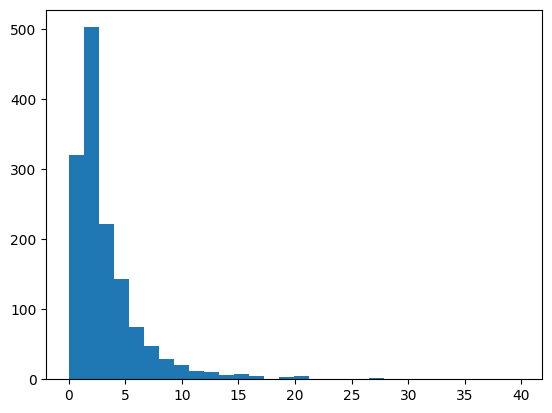

[2.06792394 4.56572109 2.84866684 ... 1.56651905 2.4779039  1.01221168]
(1417,)


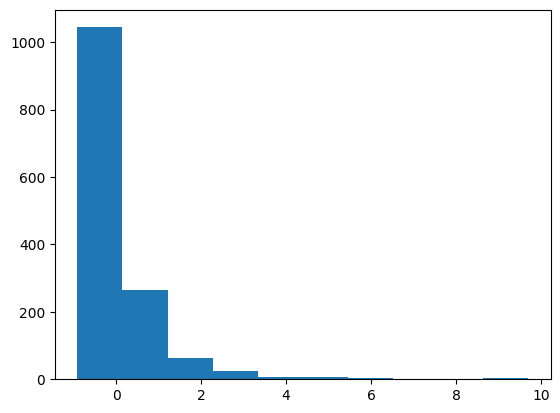

In [ ]:
print(sMRI_feature_names)
plt.hist(smri_all_saliency.flatten(),bins = 30)
plt.show()

print(smri_all_saliency)
print(smri_all_saliency.shape)
# plt.hist(smri_all_saliency.flatten())
# plt.show()
z_mean = np.mean(smri_all_saliency)
z_std = np.std(smri_all_saliency)
smri_all_saliency = (smri_all_saliency - z_mean) / z_std
plt.hist(smri_all_saliency.flatten())
plt.show()

In [ ]:
new_dk_mapping_co_sub = {}
new_dk_mapping_wm = {}

test_dk_all_name = {}
test_dk_all_saliency = {}

for i in range(len(node_names)):
  new_dk_mapping_co_sub[node_names[i]] = -100
  new_dk_mapping_wm[node_names[i]] = -100
  # new_dk_mapping_sub[node_names[i]] = -100
print(new_dk_mapping_co_sub)
print(new_dk_mapping_wm)
# print(new_dk_mapping_sub)

##### cortical
for i in range(smri_all_saliency.shape[0]):
  each_saliency = smri_all_saliency[i]
  smri_each_feature_name = sMRI_feature_names[i]
  node_name = smri_each_feature_name[0]
  # print(node_name)
  if node_name in no_match_area:
    print(smri_each_feature_name)
    print('The saliency for this no match area is: ', each_saliency)
  else:
    # print(node_name)
    # if node_name[0:3]=='ctx':
    #   if each_saliency > new_dk_mapping_co[node_name]:
    #     new_dk_mapping_co[node_name] = each_saliency + 0
    if node_name[0:3]=='wm-':
      new_name = node_name[3:]
      new_name = 'ctx-'+new_name
      if each_saliency > new_dk_mapping_wm[new_name]:
        new_dk_mapping_wm[new_name] = each_saliency + 0
        test_dk_all_name[new_name] = smri_each_feature_name
        test_dk_all_saliency[node_name] = each_saliency + 0
        # test_dk_all_saliency_list.append(each_saliency)
    else:
      if node_name == 'Left-Thalamus' or node_name == 'Right-Thalamus':
        node_name = node_name + '-Proper'
      if each_saliency > new_dk_mapping_co_sub[node_name]:
        new_dk_mapping_co_sub[node_name] = each_saliency + 0
        test_dk_all_name[node_name] = smri_each_feature_name
        test_dk_all_saliency[node_name] = each_saliency + 0
        # test_dk_all_saliency_list.append(each_saliency)

print(new_dk_mapping_co_sub)
print(new_dk_mapping_wm)
# print(new_dk_mapping_sub)



{'Left-Cerebral-White-Matter': -100, 'Left-Lateral-Ventricle': -100, 'Left-Inf-Lat-Vent': -100, 'Left-Cerebellum-White-Matter': -100, 'Left-Cerebellum-Cortex': -100, 'Left-Thalamus-Proper': -100, 'Left-Caudate': -100, 'Left-Putamen': -100, 'Left-Pallidum': -100, '3rd-Ventricle': -100, '4th-Ventricle': -100, 'Brain-Stem': -100, 'Left-Hippocampus': -100, 'Left-Amygdala': -100, 'CSF': -100, 'Left-Accumbens-area': -100, 'Left-VentralDC': -100, 'Left-vessel': -100, 'Left-choroid-plexus': -100, 'Right-Cerebral-White-Matter': -100, 'Right-Lateral-Ventricle': -100, 'Right-Inf-Lat-Vent': -100, 'Right-Cerebellum-White-Matter': -100, 'Right-Cerebellum-Cortex': -100, 'Right-Thalamus-Proper': -100, 'Right-Caudate': -100, 'Right-Putamen': -100, 'Right-Pallidum': -100, 'Right-Hippocampus': -100, 'Right-Amygdala': -100, 'Right-Accumbens-area': -100, 'Right-VentralDC': -100, 'Right-vessel': -100, 'Right-choroid-plexus': -100, 'WM-hypointensities': -100, 'non-WM-hypointensities': -100, 'Optic-Chiasm': -

In [ ]:
print(test_dk_all_name)
print(test_dk_all_saliency)

{'ctx-lh-bankssts': ['wm-lh-bankssts', 'Volume'], 'ctx-lh-caudalanteriorcingulate': ['wm-lh-caudalanteriorcingulate', 'Intensity normRange'], 'ctx-lh-caudalmiddlefrontal': ['wm-lh-caudalmiddlefrontal', 'Number of Voxels'], 'ctx-lh-cuneus': ['wm-lh-cuneus', 'Intensity normMax'], 'ctx-lh-entorhinal': ['wm-lh-entorhinal', 'Intensity normMin'], 'ctx-lh-fusiform': ['wm-lh-fusiform', 'Intensity normMax'], 'ctx-lh-inferiorparietal': ['wm-lh-inferiorparietal', 'Number of Voxels'], 'ctx-lh-inferiortemporal': ['wm-lh-inferiortemporal', 'Intensity normMax'], 'ctx-lh-isthmuscingulate': ['wm-lh-isthmuscingulate', 'Intensity normMin'], 'ctx-lh-lateraloccipital': ['wm-lh-lateraloccipital', 'Intensity normMin'], 'ctx-lh-lateralorbitofrontal': ['wm-lh-lateralorbitofrontal', 'Intensity normMax'], 'ctx-lh-lingual': ['wm-lh-lingual', 'Intensity normMax'], 'ctx-lh-medialorbitofrontal': ['wm-lh-medialorbitofrontal', 'Itensity normStdDev'], 'ctx-lh-middletemporal': ['wm-lh-middletemporal', 'Intensity normMax

[-100, 3.2051288132041083, 9.233358757818657, 0.543236784532797, 0.7221211480264204, 4.487352076345415, 0.931838956588122, 0.22337787410139895, 4.223312423422926, 8.901404818363249, 1.1402818833440573, 1.362648821443366, 2.1740997949287038, 0.36738207266834766, 3.4282697671071594, 0.02057450872351971, 4.322810325930823, 0.01842849626202359, 4.697625850989969, -100, 1.4010644740588174, 2.038014880956857, 1.003409062202176, 0.2254144095050923, 0.19845145955182145, 0.12869619994285322, 1.8991840897806718, 0.30727733644219263, 0.7663992885740509, 0.31660914905013016, 0.0716526770668121, 1.254913435247348, 0.5871539692653054, 0.9206684895170144, 1.823235904249431, 2.526516275395716, 1.0416784549178393, 4.8491766420989295, 0.3999874398666602, 3.1757523859428773, 4.564135019084703, 1.2542115889133167, -100, 1.1620241151786237, 3.6064249718653474, 0.873225474257759, 2.2283140498570657, 3.95972277834897, 0.8931402912987283, 2.212645979825108, 4.579535202910117, 1.6398836079740657, 1.42402049424

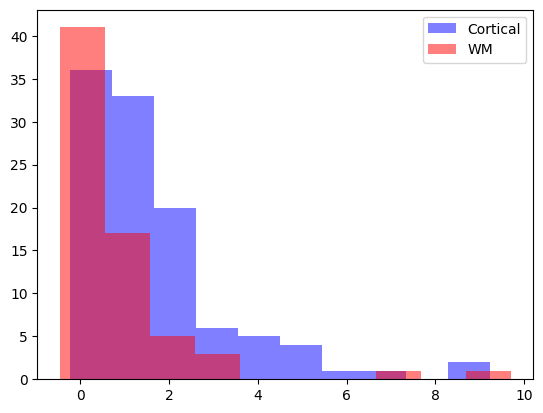

-0.24132368825215184
-0.4582470842527272
9.233358757818657
9.701425508691978


In [ ]:
co_sub_values = list(new_dk_mapping_co_sub.values())
print(co_sub_values)
wm_values = list(new_dk_mapping_wm.values())
print(wm_values)
# sub_values = list(new_dk_mapping_sub.values())
# print(sub_values)

co_sub_values = np.array(co_sub_values)
wm_values = np.array(wm_values)
# sub_values = np.array(sub_values)
plt.hist(co_sub_values[co_sub_values>-100],alpha=0.5,color='b',label='Cortical')
plt.hist(wm_values[wm_values>-100],alpha=0.5,color='r',label='WM')
# plt.hist(sub_values[sub_values>-100],alpha=0.5,color='y',label='Subcortical')
plt.legend()
plt.show()
print(min(co_sub_values[co_sub_values>-100]))
print(min(wm_values[wm_values>-100]))
# print(min(sub_values[sub_values>-100]))

print(max(co_sub_values[co_sub_values>-100]))
print(max(wm_values[wm_values>-100]))
# print(max(sub_values[sub_values>-100]))

co_sub_values = list(co_sub_values)
wm_values = list(wm_values)
# sub_values = list(sub_values)

In [ ]:
co_sub_values = sorted(co_sub_values)
wm_values = sorted(wm_values)
# sub_values = sorted(sub_values)
keys = list(new_dk_mapping_co_sub.keys())
print(keys)
print(len(keys))

new_save_smri_saliency_atlas_co_sub = np.zeros_like(dk_atlas)
new_save_smri_saliency_atlas_wm = np.zeros_like(dk_atlas)
# new_save_smri_saliency_atlas_sub = np.zeros_like(dk_atlas)
# print('brain region  intensity')
for i in range(len(keys)):
  keys_name = keys[i]
  intensity_cos_sub = new_dk_mapping_co_sub[keys_name]
  intensity_wm = new_dk_mapping_wm[keys_name]
  # intensity_sub = new_dk_mapping_sub[keys_name]
  original_name_intensity = smri_atlas_name_intensity[keys_name]

  new_save_smri_saliency_atlas_co_sub[dk_atlas==original_name_intensity] = intensity_cos_sub + 0
  new_save_smri_saliency_atlas_wm[dk_atlas==original_name_intensity] = intensity_wm + 0
  # new_save_smri_saliency_atlas_sub[dk_atlas==original_name_intensity] = intensity_sub + 0



unsorted_values_co_sub = list(new_dk_mapping_co_sub.values())
unsorted_values_wm = list(new_dk_mapping_wm.values())
# unsorted_values_sub = list(new_dk_mapping_sub.values())
co_sub_values = sorted(co_sub_values,reverse=True)
wm_values = sorted(wm_values,reverse=True)
# sub_values = sorted(sub_values,reverse=True)
print('Brain region  intensity')
for i in range(len(co_sub_values)):
  value = co_sub_values[i]
  each_index = unsorted_values_co_sub.index(value)
  name = keys[each_index]
  print(name,'    ',value)

print('\n')
print('\n')
print('\n')
print('\n')
print('\n')

print('Brain region  intensity')
for i in range(len(wm_values)):
  value = wm_values[i]
  each_index = unsorted_values_wm.index(value)
  name = keys[each_index]
  if name[0:3] == 'ctx':
    name = 'wm'+ name[3:]
  print(name,'    ',value)


# print('\n')
# print('\n')
# print('\n')
# print('\n')
# print('\n')

# print('Brain region  intensity')
# for i in range(len(sub_values)):
#   value = sub_values[i]
#   each_index = unsorted_values_sub.index(value)
#   name = keys[each_index]

#   print(name,'    ',value)



new_save_smri_saliency_atlas_co_sub_ = nib.Nifti1Image(new_save_smri_saliency_atlas_co_sub, dk_aff)
nib.save(new_save_smri_saliency_atlas_co_sub_, '/content/drive/MyDrive/ABIDE/plot_atlas/aefcn/abide_dk_smri_saliency_cor_sub.nii')
new_save_smri_saliency_atlas_wm_ = nib.Nifti1Image(new_save_smri_saliency_atlas_wm, dk_aff)
nib.save(new_save_smri_saliency_atlas_wm_, '/content/drive/MyDrive/ABIDE/plot_atlas/aefcn/abide_dk_smri_saliency_wm.nii')
# new_save_smri_saliency_atlas_sub_ = nib.Nifti1Image(new_save_smri_saliency_atlas_sub, dk_aff)
# nib.save(new_save_smri_saliency_atlas_sub_, '/content/drive/MyDrive/ABIDE/plot_atlas/abide_dk_smri_saliency_sub.nii')


['Left-Cerebral-White-Matter', 'Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent', 'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex', 'Left-Thalamus-Proper', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum', '3rd-Ventricle', '4th-Ventricle', 'Brain-Stem', 'Left-Hippocampus', 'Left-Amygdala', 'CSF', 'Left-Accumbens-area', 'Left-VentralDC', 'Left-vessel', 'Left-choroid-plexus', 'Right-Cerebral-White-Matter', 'Right-Lateral-Ventricle', 'Right-Inf-Lat-Vent', 'Right-Cerebellum-White-Matter', 'Right-Cerebellum-Cortex', 'Right-Thalamus-Proper', 'Right-Caudate', 'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area', 'Right-VentralDC', 'Right-vessel', 'Right-choroid-plexus', 'WM-hypointensities', 'non-WM-hypointensities', 'Optic-Chiasm', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior', 'CC_Anterior', 'ctx-lh-unknown', 'ctx-lh-bankssts', 'ctx-lh-caudalanteriorcingulate', 'ctx-lh-caudalmiddlefrontal', 'ctx-lh-cuneus', 'ctx-lh-entorhi

(97, 115, 97)
(97, 115, 97)
(97, 115, 97)


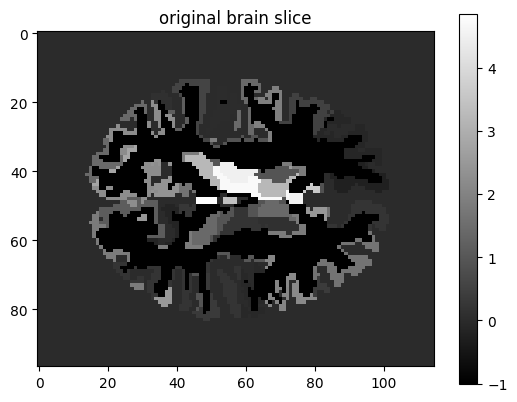

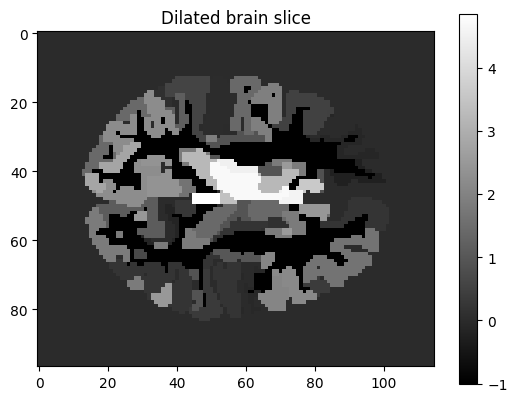

In [ ]:
from scipy.ndimage import grey_dilation
zoom_smri_saliency_map_co_sub = np.copy(new_save_smri_saliency_atlas_co_sub)
zoom_smri_saliency_map_wm = np.copy(new_save_smri_saliency_atlas_wm)
# zoom_smri_saliency_map_sub = np.copy(new_save_smri_saliency_atlas_sub)
print(new_save_smri_saliency_atlas_co_sub.shape)

# 执行膨胀操作
size = (2, 2, 2)  # 根据需要调整膨胀的大小
zoom_smri_saliency_map_co_sub = grey_dilation(zoom_smri_saliency_map_co_sub, size=size, mode='nearest')
print(zoom_smri_saliency_map_co_sub.shape)
zoom_smri_saliency_map_wm = grey_dilation(zoom_smri_saliency_map_wm, size=size, mode='nearest')
print(zoom_smri_saliency_map_wm.shape)
# new_save_smri_saliency_atlas_sub = grey_dilation(new_save_smri_saliency_atlas_sub, size=size, mode='nearest')
# print(new_save_smri_saliency_atlas_sub.shape)

plt.imshow(new_save_smri_saliency_atlas_co_sub[:, :, new_save_smri_saliency_atlas_co_sub.shape[2]//2], cmap='gray', vmin=-1)
plt.title('original brain slice')
plt.colorbar()
plt.show()

plt.imshow(zoom_smri_saliency_map_co_sub[:, :, zoom_smri_saliency_map_co_sub.shape[2]//2], cmap='gray', vmin=-1)
plt.title('Dilated brain slice')
plt.colorbar()
plt.show()

zoom_smri_saliency_map_co_sub_ = nib.Nifti1Image(zoom_smri_saliency_map_co_sub, dk_aff)
nib.save(zoom_smri_saliency_map_co_sub_, '/content/drive/MyDrive/ABIDE/plot_atlas/aefcn/abide_dk_smri_saliency_cor_sub_dilation2.nii')
zoom_smri_saliency_map_wm_ = nib.Nifti1Image(zoom_smri_saliency_map_wm, dk_aff)
nib.save(zoom_smri_saliency_map_wm_, '/content/drive/MyDrive/ABIDE/plot_atlas/aefcn/abide_dk_smri_saliency_wm_dilation2.nii')
# zoom_smri_saliency_map_sub_ = nib.Nifti1Image(zoom_smri_saliency_map_sub, dk_aff)
# nib.save(zoom_smri_saliency_map_sub_, '/content/drive/MyDrive/ABIDE/plot_atlas/abide_dk_smri_saliency_sub_dilation2.nii')

(97, 115, 97)
(97, 115, 97)
(97, 115, 97)


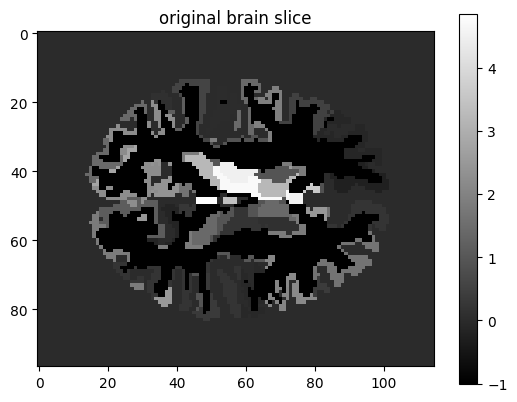

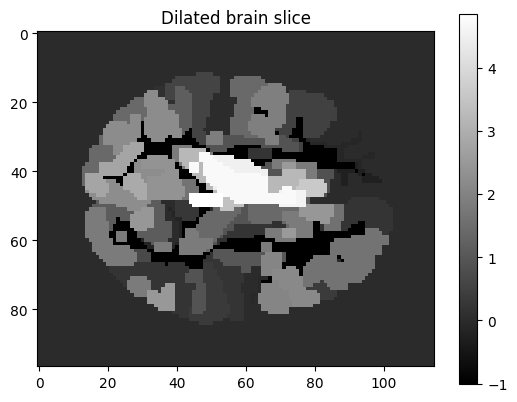

In [ ]:
from scipy.ndimage import grey_dilation
zoom_smri_saliency_map_co_sub = np.copy(new_save_smri_saliency_atlas_co_sub)
zoom_smri_saliency_map_wm = np.copy(new_save_smri_saliency_atlas_wm)
# zoom_smri_saliency_map_sub = np.copy(new_save_smri_saliency_atlas_sub)
print(new_save_smri_saliency_atlas_co_sub.shape)

# 执行膨胀操作
size = (3, 3, 3)  # 根据需要调整膨胀的大小
zoom_smri_saliency_map_co_sub = grey_dilation(zoom_smri_saliency_map_co_sub, size=size, mode='nearest')
print(zoom_smri_saliency_map_co_sub.shape)
zoom_smri_saliency_map_wm = grey_dilation(zoom_smri_saliency_map_wm, size=size, mode='nearest')
print(zoom_smri_saliency_map_wm.shape)
# new_save_smri_saliency_atlas_sub = grey_dilation(new_save_smri_saliency_atlas_sub, size=size, mode='nearest')
# print(new_save_smri_saliency_atlas_sub.shape)

plt.imshow(new_save_smri_saliency_atlas_co_sub[:, :, new_save_smri_saliency_atlas_co_sub.shape[2]//2], cmap='gray', vmin=-1)
plt.title('original brain slice')
plt.colorbar()
plt.show()

plt.imshow(zoom_smri_saliency_map_co_sub[:, :, zoom_smri_saliency_map_co_sub.shape[2]//2], cmap='gray', vmin=-1)
plt.title('Dilated brain slice')
plt.colorbar()
plt.show()

zoom_smri_saliency_map_co_sub_ = nib.Nifti1Image(zoom_smri_saliency_map_co_sub, dk_aff)
nib.save(zoom_smri_saliency_map_co_sub_, '/content/drive/MyDrive/ABIDE/plot_atlas/aefcn/abide_dk_smri_saliency_cor_sub_dilation3.nii')
zoom_smri_saliency_map_wm_ = nib.Nifti1Image(zoom_smri_saliency_map_wm, dk_aff)
nib.save(zoom_smri_saliency_map_wm_, '/content/drive/MyDrive/ABIDE/plot_atlas/aefcn/abide_dk_smri_saliency_wm_dilation3.nii')
# zoom_smri_saliency_map_sub_ = nib.Nifti1Image(zoom_smri_saliency_map_sub, dk_aff)
# nib.save(zoom_smri_saliency_map_sub_, '/content/drive/MyDrive/ABIDE/plot_atlas/abide_dk_smri_saliency_sub_dilation2.nii')

# Print the box plots for all the important smri brain regions

In [ ]:
print(smri_all_saliency.shape)
print(test_dk_all_saliency)
print(test_dk_all_name)
top_smri_values = np.array(list(test_dk_all_saliency.values()))
values_dk_all = np.array(list(test_dk_all_saliency.values()))
name_dk_all = list(test_dk_all_saliency.keys())
top_smri_values = sorted(top_smri_values, reverse=True)

for i in range(len(top_smri_values)):
  each_index = np.where(smri_all_saliency==top_smri_values[i])
  special_feature_index = each_index[0][0]

  name = sMRI_feature_names[special_feature_index]
  each_intensity = top_smri_values[i]
  print(str(i+1),'   ',name,'   ',each_intensity)

  tp_group = []
  fp_group = []
  tn_group = []
  fn_group = []

  for j in range(sMRI_features.shape[0]):
    subject_type = dist_all_subjects[str(j)]
    if subject_type == 'tp':
      tp_group.append(sMRI_features[j,special_feature_index])
    if subject_type == 'tn':
      tn_group.append(sMRI_features[j,special_feature_index])
    if subject_type == 'fp':
      fp_group.append(sMRI_features[j,special_feature_index])
    if subject_type == 'fn':
      fn_group.append(sMRI_features[j,special_feature_index])

  t,p = stats.ttest_ind(a=tp_group, b=tn_group, equal_var=True)
  print('The P-value between TP and TN groups is: ',p)
  ################################### box plot #################################################
  ################################### box plot #################################################
  ################################### box plot #################################################

  all_data = [tp_group, fn_group, tn_group, fp_group]
  # print(tp_group)
  # print(fp_group)
  # print(tn_group)
  # print(fn_group)
  four_labels = ['TP', 'FN', 'TN', 'FP']
  plt.boxplot(all_data, vert=True,patch_artist=False,labels=four_labels,medianprops=dict(color="black"))
  plt.ylabel('Normalized feature intensity',fontsize=14)
  plt.xticks(fontsize=14)
  plt.show()




# test_index = np.where(smri_all_saliency==top_smri_values[0])


# print(len(top_smri_values))
# print(test_index)

Give a specific feature name, obtain all the corresponding saliency values and plot the box plots

['wm-rh-isthmuscingulate', 'Number of Voxels']     0.6828407992244563
The P-value between TP and TN groups is:  0.07344421050186635
The P-value between autism and TD groups is:  0.20287878210074933


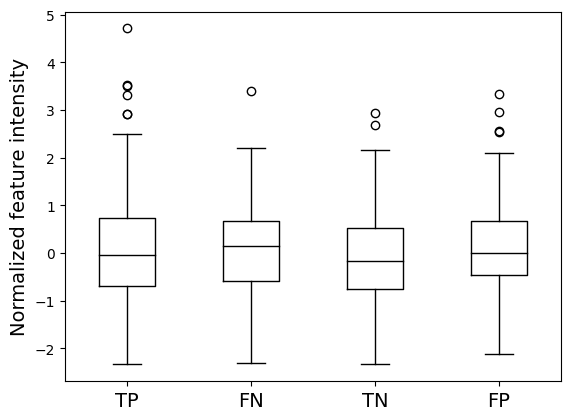

['wm-rh-isthmuscingulate', 'Volume']     0.6498356259594635
The P-value between TP and TN groups is:  0.08705240919030036
The P-value between autism and TD groups is:  0.22667118955486407


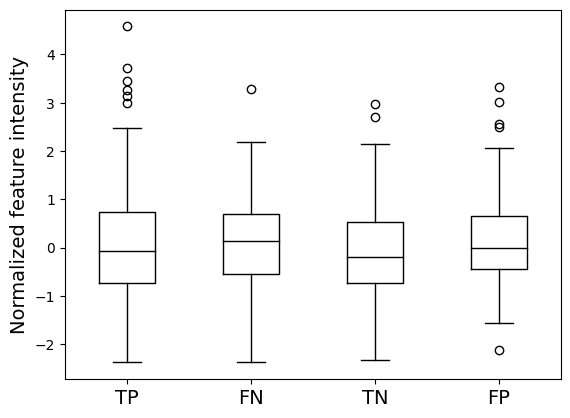

['wm-rh-isthmuscingulate', 'Intensity normMean']     -0.26848448536122804
The P-value between TP and TN groups is:  0.34772511874909584
The P-value between autism and TD groups is:  0.8374715944433725


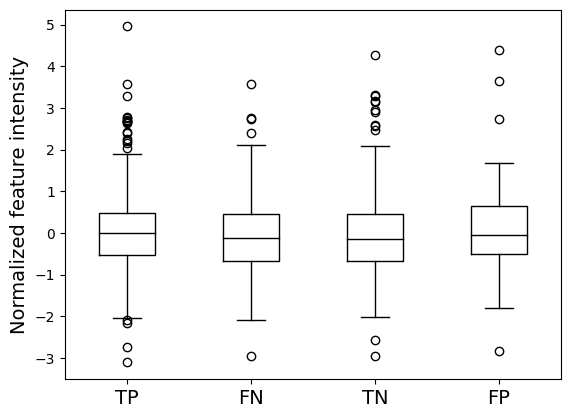

['wm-rh-isthmuscingulate', 'Itensity normStdDev']     0.16058060266923566
The P-value between TP and TN groups is:  4.0557548605440084e-07
The P-value between autism and TD groups is:  0.00012370446091086387


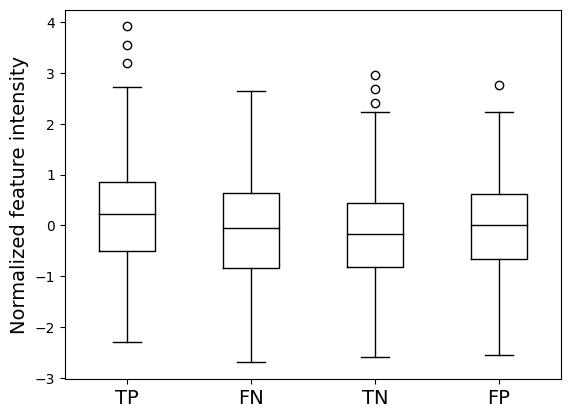

['wm-rh-isthmuscingulate', 'Intensity normMin']     7.261413947445976
The P-value between TP and TN groups is:  1.0467870525792573e-08
The P-value between autism and TD groups is:  8.603398991907119e-06


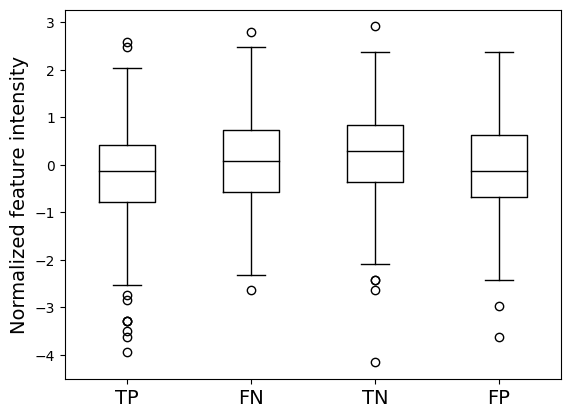

['wm-rh-isthmuscingulate', 'Intensity normMax']     -0.14454665933227343
The P-value between TP and TN groups is:  5.4510377794782855e-05
The P-value between autism and TD groups is:  0.004797026968737973


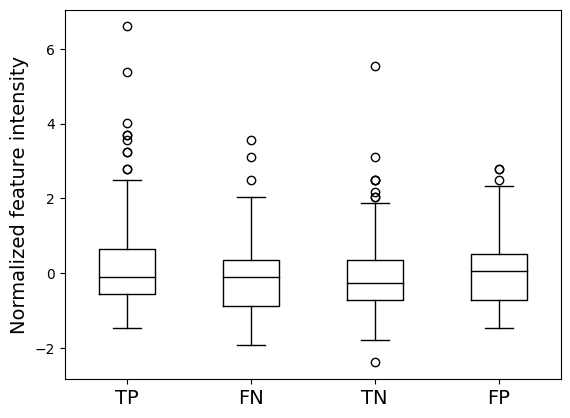

['wm-rh-isthmuscingulate', 'Intensity normRange']     6.2386342582014755
The P-value between TP and TN groups is:  5.850073723613022e-11
The P-value between autism and TD groups is:  1.0532633955766713e-06


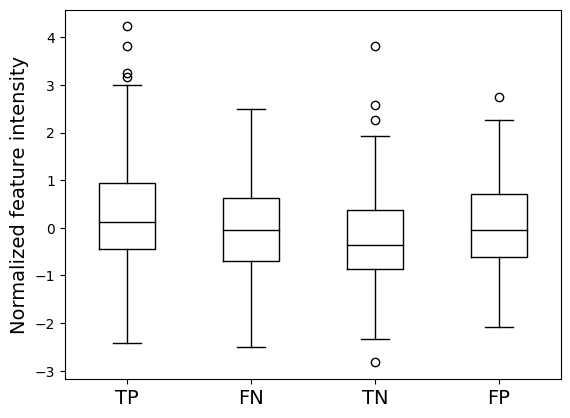

In [ ]:
feature_name = 'wm-rh-isthmuscingulate'


for i in range(len(sMRI_feature_names)):
  name = sMRI_feature_names[i][0]
  each_saliency = smri_all_saliency[i]
  if name == feature_name:
    print(sMRI_feature_names[i],'   ',each_saliency)
    tp_group = []
    fp_group = []
    tn_group = []
    fn_group = []
    for j in range(sMRI_features.shape[0]):
      subject_type = dist_all_subjects[str(j)]
      if subject_type == 'tp':
        tp_group.append(sMRI_features[j,i])
      if subject_type == 'tn':
        tn_group.append(sMRI_features[j,i])
      if subject_type == 'fp':
        fp_group.append(sMRI_features[j,i])
      if subject_type == 'fn':
        fn_group.append(sMRI_features[j,i])
    t,p = stats.ttest_ind(a=tp_group, b=tn_group, equal_var=True)
    print('The P-value between TP and TN groups is: ',p)
    t,p = stats.ttest_ind(a=tp_group+fn_group, b=tn_group+fp_group, equal_var=True)
    print('The P-value between autism and TD groups is: ',p)
    ################################### box plot #################################################
    ################################### box plot #################################################
    ################################### box plot #################################################

    all_data = [tp_group, fn_group, tn_group, fp_group]
    # print(tp_group)
    # print(fp_group)
    # print(tn_group)
    # print(fn_group)
    four_labels = ['TP', 'FN', 'TN', 'FP']
    plt.boxplot(all_data, vert=True,patch_artist=False,labels=four_labels,medianprops=dict(color="black"))
    plt.ylabel('Normalized feature intensity',fontsize=14)
    plt.xticks(fontsize=14)
    plt.show()


In [ ]:

from openpyxl import Workbook

# 创建一个工作簿
wb = Workbook()

# 选择默认的活动工作表
ws = wb.active


# 添加数据到单元格
ws['A1'] = 'The top 100 structural features'
ws['B1'] = 'Desikan-Killiany atlas  regions'
ws['C1'] = 'feature names'


print(smri_all_saliency.shape)
ranking_smri = np.copy(smri_all_saliency)
ranking_smri = sorted(ranking_smri,reverse=True)
ranking_smri = ranking_smri[0:100]
print(len(ranking_smri))

for i in range(len(ranking_smri)):
  saliency_value = ranking_smri[i]
  index_ = np.where(smri_all_saliency==saliency_value)
  index_ = index_[0][0]
  smri_each_feature_name = sMRI_feature_names[index_]
  print(smri_each_feature_name)
  brain_region_name = smri_each_feature_name[0]
  feature_name = smri_each_feature_name[1]

  row = i+2
  number_name = "A" + str(row)
  brain_region_1_name = "B" + str(row)
  feature_name_1 = "C" +str(row)

  ws[number_name] = str(i+1)
  ws[brain_region_1_name] = brain_region_name
  ws[feature_name_1] = feature_name

# 保存工作簿到文件
wb.save("/content/drive/MyDrive/ABIDE/plot_atlas/aefcn/smri_example.xlsx")





# for i in range(200):
#   row = (i+1)*2
#   number_name = "A" + str(row)
#   brain_region_1_name = "B" + str(row)
#   brain_region_2_name = "B" + str(row+1)
#   corresponding_brain_region_1_name = "C" +str(row)
#   corresponding_brain_region_2_name = "C" +str(row+1)

#   ws[number_name] = str(i+1)

#   saliency_value = rank_fmri[i]
#   # print(saliency_value)
#   index_ = np.where(fmri_all_saliency_copy==saliency_value)
#   # print(index_)
#   index_ = index_[0][0]
#   # print(index_)
#   brain_region_1 = fMRI_feature_names[index_][0]
#   brain_region_2 = fMRI_feature_names[index_][1]

#   print(brain_region_1, ' ',brain_region_2, '   ',saliency_value)

#   ws[brain_region_1_name] = brain_region_1
#   ws[brain_region_2_name] = brain_region_2
#   ws[corresponding_brain_region_1_name] = excel_cc200_brain_names[str(brain_region_1)]
#   ws[corresponding_brain_region_2_name] = excel_cc200_brain_names[str(brain_region_2)]






# 保存工作簿到文件
# wb.save("/content/drive/MyDrive/ABIDE/plot_atlas/fmri_example.xlsx")

##### cortical
# for i in range(smri_all_saliency.shape[0]):
#   each_saliency = smri_all_saliency[i]
#   smri_each_feature_name = sMRI_feature_names[i]
#   node_name = smri_each_feature_name[0]
#   # print(node_name)
#   if node_name in no_match_area:
#     print(smri_each_feature_name)
#     print('The saliency for this no match area is: ', each_saliency)
#   else:
#     # print(node_name)
#     # if node_name[0:3]=='ctx':
#     #   if each_saliency > new_dk_mapping_co[node_name]:
#     #     new_dk_mapping_co[node_name] = each_saliency + 0
#     if node_name[0:3]=='wm-':
#       new_name = node_name[3:]
#       new_name = 'ctx-'+new_name
#       if each_saliency > new_dk_mapping_wm[new_name]:
#         new_dk_mapping_wm[new_name] = each_saliency + 0
#         test_dk_all_name[new_name] = smri_each_feature_name
#         test_dk_all_saliency[node_name] = each_saliency + 0
#         # test_dk_all_saliency_list.append(each_saliency)
#     else:
#       if node_name == 'Left-Thalamus' or node_name == 'Right-Thalamus':
#         node_name = node_name + '-Proper'
#       if each_saliency > new_dk_mapping_co_sub[node_name]:
#         new_dk_mapping_co_sub[node_name] = each_saliency + 0
#         test_dk_all_name[node_name] = smri_each_feature_name
#         test_dk_all_saliency[node_name] = each_saliency + 0
#         # test_dk_all_saliency_list.append(each_saliency)






(1417,)
100
['wm-lh-isthmuscingulate', 'Intensity normMin']
['Left-Inf-Lat-Vent', 'Volume']
['3rd-Ventricle', 'Volume']
['wm-rh-isthmuscingulate', 'Intensity normMin']
['ctx-rh-temporalpole', 'CurvInd']
['3rd-Ventricle', 'Number of Voxels']
['wm-rh-isthmuscingulate', 'Intensity normRange']
['ctx-lh-parahippocampal', 'ThickStd']
['Left-Inf-Lat-Vent', 'Number of Voxels']
['CC_Posterior', 'Intensity normMin']
['Left-choroid-plexus', 'Intensity normMean']
['ctx-lh-inferiortemporal', 'FoldInd']
['CC_Mid_Anterior', 'Intensity normMin']
['Left-Thalamus', 'Intensity normMax']
['Left-VentralDC', 'Volume']
['wm-lh-isthmuscingulate', 'Intensity normRange']
['Left-Pallidum', 'Intensity normMax']
['ctx-lh-entorhinal', 'CurvInd']
['ctx-lh-caudalanteriorcingulate', 'FoldInd']
['wm-rh-parahippocampal', 'Volume']
['CSF', 'Volume']
['Left-VentralDC', 'Number of Voxels']
['wm-lh-transversetemporal', 'Number of Voxels']
['wm-rh-parsorbitalis', 'Intensity normMax']
['Left-Lateral-Ventricle', 'Itensity norm

{'Left-Cerebral-White-Matter': 0, 'Left-Lateral-Ventricle': 0, 'Left-Inf-Lat-Vent': 0, 'Left-Cerebellum-White-Matter': 0, 'Left-Cerebellum-Cortex': 0, 'Left-Thalamus-Proper': 0, 'Left-Caudate': 0, 'Left-Putamen': 0, 'Left-Pallidum': 0, '3rd-Ventricle': 0, '4th-Ventricle': 0, 'Brain-Stem': 0, 'Left-Hippocampus': 0, 'Left-Amygdala': 0, 'CSF': 0, 'Left-Accumbens-area': 0, 'Left-VentralDC': 0, 'Left-vessel': 0, 'Left-choroid-plexus': 0, 'Right-Cerebral-White-Matter': 0, 'Right-Lateral-Ventricle': 0, 'Right-Inf-Lat-Vent': 0, 'Right-Cerebellum-White-Matter': 0, 'Right-Cerebellum-Cortex': 0, 'Right-Thalamus-Proper': 0, 'Right-Caudate': 0, 'Right-Putamen': 0, 'Right-Pallidum': 0, 'Right-Hippocampus': 0, 'Right-Amygdala': 0, 'Right-Accumbens-area': 0, 'Right-VentralDC': 0, 'Right-vessel': 0, 'Right-choroid-plexus': 0, 'WM-hypointensities': 0, 'non-WM-hypointensities': 0, 'Optic-Chiasm': 0, 'CC_Posterior': 0, 'CC_Mid_Posterior': 0, 'CC_Central': 0, 'CC_Mid_Anterior': 0, 'CC_Anterior': 0, 'ctx-lh

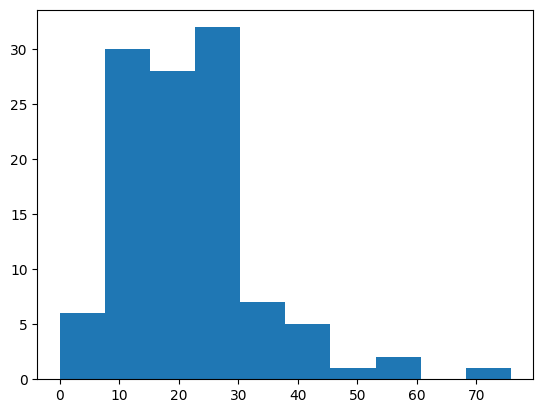

75.80844432587918


In [ ]:
# values = sorted(values)
# print(values)
# print(len(values))
# keys = list(new_dk_mapping.keys())
# print(keys)
# print(len(keys))

# new_save_smri_saliency_atlas = np.zeros_like(dk_atlas)
# # print('brain region  intensity')
# for i in range(len(keys)):
#   keys_name = keys[i]
#   intensity = new_dk_mapping[keys_name]
#   original_name_intensity = smri_atlas_name_intensity[keys_name]
#   if intensity == 0:
#     new_save_smri_saliency_atlas[dk_atlas==original_name_intensity] = 3
#     print(keys_name, '   ',3)
#   else:
#     # each_index = values.index(intensity)
#     new_save_smri_saliency_atlas[dk_atlas==original_name_intensity] = intensity
#     # print(keys_name, '   ', intensity)



# unsorted_values = list(new_dk_mapping.values())
# values = sorted(values,reverse=True)
# print('Brain region  intensity')
# for i in range(len(values)):
#   value = values[i]
#   each_index = unsorted_values.index(value)
#   name = keys[each_index]
#   print(name,'    ',value)



# new_save_smri_saliency_atlas_ = nib.Nifti1Image(new_save_smri_saliency_atlas, dk_aff)
# nib.save(new_save_smri_saliency_atlas_, '/content/drive/MyDrive/ABIDE/plot_atlas/abide_dk_smri_saliency.nii')


[0, 0, 0, 0, 4.741611148357166, 7.518018798440868, 7.90869853334264, 7.969517560178843, 8.06586976377974, 8.093587840860323, 8.293865296168642, 9.049267413816663, 9.215269744991241, 9.249951984758857, 9.282468908505471, 9.388231701537844, 9.844552880443402, 10.035168848159145, 10.402342140111733, 10.500518169803815, 10.753979695958094, 11.248917398009663, 11.441502661946334, 12.318799142509905, 12.49343066383389, 12.539264227798988, 13.012909047562733, 13.132220691902749, 13.592332986853714, 13.694744809044339, 13.764074585557186, 14.066999565667292, 14.42831100261471, 14.435278384167221, 14.871573595940076, 14.984012137102171, 15.268544970680352, 15.498490612303902, 15.803440320013197, 16.073836266092982, 16.114559924124944, 17.024664393135602, 17.868173715634462, 18.382352573144235, 18.605761872313956, 18.60779679290731, 19.564339051411874, 19.603450942000105, 19.86202315435857, 19.932281260212406, 19.932609758342792, 20.213058157619265, 20.32338991160855, 20.353398175497887, 20.3540

(97, 115, 97)
(97, 115, 97)


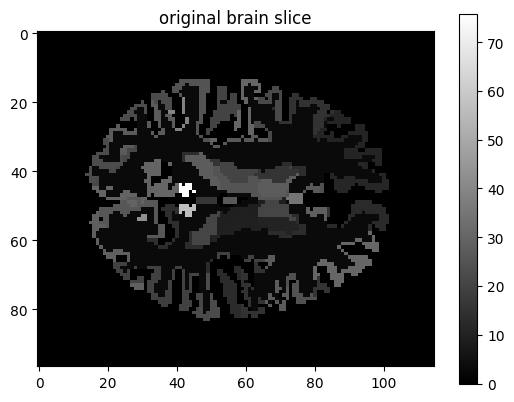

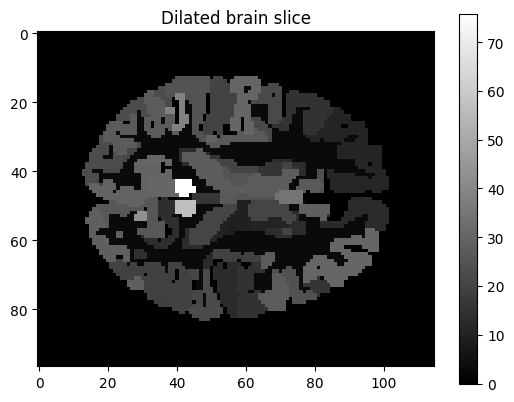

In [ ]:
from scipy.ndimage import grey_dilation
zoom_smri_saliency_map = np.copy(new_save_smri_saliency_atlas)
print(new_save_smri_saliency_atlas.shape)

# 执行膨胀操作
size = (2, 2, 2)  # 根据需要调整膨胀的大小
zoom_smri_saliency_map = grey_dilation(zoom_smri_saliency_map, size=size, mode='nearest')
print(zoom_smri_saliency_map.shape)

plt.imshow(new_save_smri_saliency_atlas[:, :, new_save_smri_saliency_atlas.shape[2]//2], cmap='gray')
plt.title('original brain slice')
plt.colorbar()
plt.show()

plt.imshow(zoom_smri_saliency_map[:, :, zoom_smri_saliency_map.shape[2]//2], cmap='gray')
plt.title('Dilated brain slice')
plt.colorbar()
plt.show()

zoom_smri_saliency_map_ = nib.Nifti1Image(zoom_smri_saliency_map, dk_aff)
nib.save(zoom_smri_saliency_map_, '/content/drive/MyDrive/ABIDE/plot_atlas/abide_dk_smri_saliency_dilation2.nii')

(97, 115, 97)
(97, 115, 97)


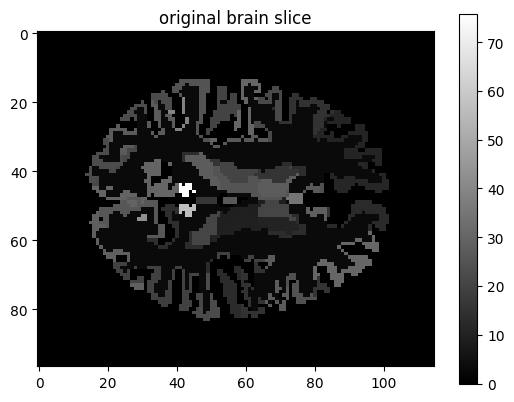

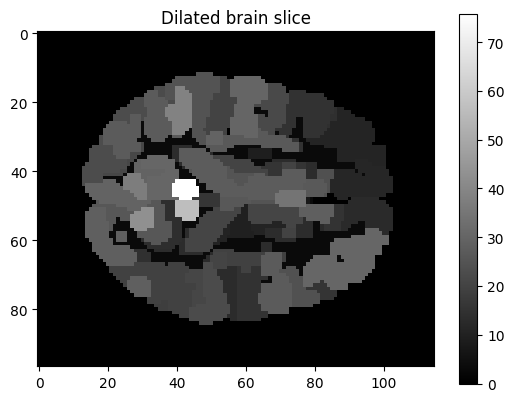

In [ ]:
from scipy.ndimage import grey_dilation
zoom_smri_saliency_map = np.copy(new_save_smri_saliency_atlas)
print(new_save_smri_saliency_atlas.shape)

# 执行膨胀操作
size = (3, 3, 3)  # 根据需要调整膨胀的大小
zoom_smri_saliency_map = grey_dilation(zoom_smri_saliency_map, size=size, mode='nearest')
print(zoom_smri_saliency_map.shape)

plt.imshow(new_save_smri_saliency_atlas[:, :, new_save_smri_saliency_atlas.shape[2]//2], cmap='gray')
plt.title('original brain slice')
plt.colorbar()
plt.show()

plt.imshow(zoom_smri_saliency_map[:, :, zoom_smri_saliency_map.shape[2]//2], cmap='gray')
plt.title('Dilated brain slice')
plt.colorbar()
plt.show()

zoom_smri_saliency_map_ = nib.Nifti1Image(zoom_smri_saliency_map, dk_aff)
nib.save(zoom_smri_saliency_map_, '/content/drive/MyDrive/ABIDE/plot_atlas/abide_dk_smri_saliency_dilation3.nii')

# The generation of surface file

In [ ]:
# cerebellum is too big for cc200, a little bit big for dk
# after 3/4, cerebellum atlas is a bit bigger than cc200, while a bit smaller for dk
# maybe try 3/5 for cc200, while 4/5 for dk

template_ratio_cc = 21/20  # 对CC200 有点大，对DK有点小
print(template_ratio_cc)
template_path = '/content/drive/MyDrive/ABIDE/plot_atlas/'
template_cere = template_path + 'BrainMesh_Ch2withCerebellum.txt'
template = template_path + 'BrainMesh_ICBM152_smoothed.txt'

test = '/content/drive/MyDrive/ABIDE/plot_atlas/test_cere_dk_2120.txt'
# 打开文件
with open(test, 'r') as file:
    # 读取文件内容
  lines  = file.readlines()

for i in range(2,77126):
  current_line = lines[i].split()
  current_line = [np.float32(num)*template_ratio_cc for num in current_line]
  lines[i] = ' '.join(map(str, current_line)) + '\n'
  print(lines[i])

with open(test, 'w') as file:
    file.writelines(lines)



流式输出内容被截断，只能显示最后 5000 行内容。
-27.337883377075197 -87.99176559448243 -34.29845123291016

33.63020896911621 -88.64570846557618 -34.18583450317383

31.80938358306885 -89.0464599609375 -33.68835983276367

-30.72293815612793 20.252826690673828 -35.05031890869141

-33.016744995117186 20.641722106933596 -35.78949737548828

-29.228463363647464 19.179731369018555 -35.95968017578125

-49.22889175415039 18.53565788269043 -35.29211883544922

52.9671895980835 17.917227172851565 -35.50653762817383

-51.55269927978516 16.515694427490235 -35.0934814453125

-24.215937423706055 16.035819625854494 -35.46098785400391

57.499464225769046 14.564328002929688 -34.780897521972655

30.19335994720459 15.211461639404298 -35.132494354248045

-53.38186798095703 14.011850738525391 -35.145391845703124

-22.322641754150393 12.237844848632813 -35.88533935546875

59.1056625366211 9.948980712890625 -35.61990737915039

-40.22038650512695 8.416598510742189 -36.11122970581055

-42.196875 8.296812057495117 -35.84461212158203



In [ ]:

names = ['X', 'Y', 'Z']

skiprows= list(range(0,2))
table_left = pd.read_table(template_cere, sep='\s+',names=names,
						  skiprows=skiprows)
print(table_left)
X_array = table_left['X'].values.tolist()
Y_array = table_left['Y'].values.tolist()
Z_array = table_left['Z'].values.tolist()


### Vertex coordinate
cor_X = X_array[0:77124]
cor_Y = Y_array[0:77124]
cor_Z = Z_array[0:77124]

### Triangle faces number: 154244
Triangle_number = int(X_array[77124])

index_X = X_array[77125:]
index_Y = Y_array[77125:]
index_Z = Z_array[77125:]

print(cor_X[77123])
print(Triangle_number)
print(index_X[-1])

with open(template_path+'test_cere.txt', 'a') as file:
  file.write('#This surface is gnerated by using the function isosurface in matlab on ch2 template')
  file.write('\n')
  file.write('77124') # Vertex number
  file.write('\n')

for i in range(len(cor_X)):
  print(i)
  with open(template_path+'test_cere.txt', 'a') as file:
    file.write(str(cor_X[i] * template_ratio))
    file.write(' ')
    file.write(str(cor_Y[i] * template_ratio))
    file.write(' ')
    file.write(str(cor_Z[i] * template_ratio))
    file.write('\n')

with open(template_path+'test_cere.txt', 'a') as file:
  file.write(str(Triangle_number))
  file.write('\n')

for i in range(len(index_X)):
  print(i)
  with open(template_path+'test_cere.txt', 'a') as file:
    file.write(str(index_X[i]))
    file.write(' ')
    file.write(str(index_Y[i]))
    file.write(' ')
    file.write(str(index_Z[i]))
    file.write('\n')


流式输出内容被截断，只能显示最后 5000 行内容。
149244
149245
149246
149247
149248
149249
149250
149251
149252
149253
149254
149255
149256
149257
149258
149259
149260
149261
149262
149263
149264
149265
149266
149267
149268
149269
149270
149271
149272
149273
149274
149275
149276
149277
149278
149279
149280
149281
149282
149283
149284
149285
149286
149287
149288
149289
149290
149291
149292
149293
149294
149295
149296
149297
149298
149299
149300
149301
149302
149303
149304
149305
149306
149307
149308
149309
149310
149311
149312
149313
149314
149315
149316
149317
149318
149319
149320
149321
149322
149323
149324
149325
149326
149327
149328
149329
149330
149331
149332
149333
149334
149335
149336
149337
149338
149339
149340
149341
149342
149343
149344
149345
149346
149347
149348
149349
149350
149351
149352
149353
149354
149355
149356
149357
149358
149359
149360
149361
149362
149363
149364
149365
149366
149367
149368
149369
149370
149371
149372
149373
149374
149375
149376
149377
149378
149379
149380
149381
149382
